# Mercedes Benz Greener Manufacturing - Kaggle

## By Chirag Shetty
<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/6565/media/daimler-mercedes%20V02.jpg">



## 1. Problem Statement

- An automobile has various components like, engine, chassis, steering, suspension, transmission etc which work together in tandem to provide the driving experience. These systems can be thought of as building blocks of an automobile that has to be fit together to form a vehicle. These building blocks can have variations in them in accordance with the purpose they’re being used for. While building a vehicle the manufacturer has to take into account the different ways these components fit and interact with each other, for which the vehicle has to be tested rigorously before its sent on road.



- The time it takes to test the performance, comfort, reliability and safety of a vehicle is highly correlated with the type of component it’s made of. Testing cars is expensive hence an entry level passenger car does not undergo the same criteria for testing as a high end luxury car, depending on the components and the type of car the test time may vary. To accurately estimate the test time required one has to account for each and every configuration of the components and their interaction, which would be a complex and time consuming process if done non-algorithmically, hence the need for a machine learning solution. 


- A dataset has been prepared by the engineers in Daimler to tackle this problem. The dataset contains permutations of car features, configurations and different testing methods applied with their respective time required for testing, the features are anonymized i.e. the name of the features are not interpretable. The dataset mainly consists of binary and categorical data, where the binary data represents the type of test being carried out and the categorical data represents the features of the vehicle. The goal of this case study is to provide a model that can estimate the time with the least amount of error. The primary metric for evaluation of the model is the Coefficient of Determination also called the R-squared. It can be interpreted as a rescaled version of the mean-squared error. In essence it compares the performance of model with mean-model i.e a model that outputs the mean value of the target for all inputs.

$$
R-squared = 1 - \frac{\sum_{i}^N(y_{i} - \hat{y})^2}{\sum_{i}^N(y_{i} - \bar{y})^2}
$$


## 2. Dataset

- This dataset contains an anonymized set of variables, each representing a custom feature in a Mercedes car. For example, a variable could be 4WD, added air suspension, or a head-up display.

- The ground truth is labeled ‘y’ and represents the time (in seconds) that the car took to pass testing for each variable.

**File descriptions**
- Variables with letters are categorical. Variables with 0/1 are binary values.

    1. **train.csv** - the training set
    2. **test.csv** - the test set, you must predict the 'y' variable for the 'ID's in this file
    3. **sample_submission.csv** - a sample submission file in the correct format


In [ ]:
# !wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.193 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/6565/44042/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1605594787&Signature=eRLZ6uJ1BjCPVPQZwEkp25uc69mWCMhEGQmDh56eKFl2Ik6rOBkHsvBl558XvWzTTafvfmMiiLjKP2lxVjegevUP1yy5qJQ1VT0NgR48WOBhR2JRwULyfLZoapQiZ9rQ3UXOmPLAqWkYujLuRCU655Aap9z45fTf2Zwt28sl2HNWuCxMbu2vASMq17YnAMKGNG1kfuBJcOxgGbQRXx8V1exV8KvvA4FPuJS0QTMPFbR7pZ9TYOO%2BW2Fpc8JJALstnjKnB%2F56w0L25bN1xYk6%2Bc7%2FiXDbduk8bBEOeW8Ly5zQH8Ki7WMnmPbnW8weIvk%2BBLljDxnsIjxmSyDR7FvyiQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dmercedes-benz-greener-manufacturing.zip" -c -O 'mercedes-benz-greener-manufacturing.zip'
# !unzip mercedes-benz-greener-manufacturing.zip
# !unzip train.csv.zip
# !unzip test.csv.zip
# !pip install category-encoders

## 3. Exploratory Data Analysis

In [ ]:
import scipy
import pickle

import category_encoders as ce
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns

from sklearn.feature_selection import RFECV
from xgboost                   import XGBRegressor
from sklearn.model_selection   import train_test_split
from scipy.stats               import boxcox, norm
from scipy.special             import inv_boxcox
from sklearn.metrics           import r2_score, make_scorer
from tabulate                  import tabulate

import warnings
warnings.simplefilter('ignore')
sns.set_style('whitegrid')

In [ ]:
train = pd.read_csv('train.csv')
print(train.shape)
train.head()

(4209, 378)


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
percentile25 = np.percentile(train.y.tolist(), 25)
percentile50 = np.percentile(train.y.tolist(), 50)
percentile75 = np.percentile(train.y.tolist(), 75)
percentile99 = np.percentile(train.y.tolist(), 99)
mean         = train.y.mean()

In [ ]:
categorical_columns = list()
binary_columns      = list()

for col in train.columns:
    if   2 < train[col].nunique() < 50:
        categorical_columns.append(col)
    elif train[col].nunique() == 2:
        binary_columns.append(col)
        
data_summary = pd.DataFrame()
data_summary['Summary'] = ['Number of samples', 'Number of Features', 'Number of Categorical Features', 'Number of Binary Features', 'Minimum test-time (y) in seconds', 'Mean test-time (y) in seconds', 'Median test-time (y) in seconds', 'Maximum test-time (y) in seconds']
data_summary['-']     = [train.shape[0], train.shape[1]-1, len(categorical_columns), len(binary_columns), train.y.min(), round(mean,2), percentile50, train.y.max()]
#data_summary['Value']     = data_summary['Value'].apply(lambda x: round(x))

print(tabulate(data_summary, headers='keys', showindex=False, tablefmt='fancy_grid'))

╒══════════════════════════════════╤═════════╕
│ Summary                          │       - │
╞══════════════════════════════════╪═════════╡
│ Number of samples                │ 4209    │
├──────────────────────────────────┼─────────┤
│ Number of Features               │  377    │
├──────────────────────────────────┼─────────┤
│ Number of Categorical Features   │    8    │
├──────────────────────────────────┼─────────┤
│ Number of Binary Features        │  356    │
├──────────────────────────────────┼─────────┤
│ Minimum test-time (y) in seconds │   72.11 │
├──────────────────────────────────┼─────────┤
│ Mean test-time (y) in seconds    │  100.67 │
├──────────────────────────────────┼─────────┤
│ Median test-time (y) in seconds  │   99.15 │
├──────────────────────────────────┼─────────┤
│ Maximum test-time (y) in seconds │  265.32 │
╘══════════════════════════════════╧═════════╛


### 3.1 Target Variable - 'y'

In [ ]:
train[['y']].describe()

,y
count,4209.000000
mean,100.669318
std,12.679381
min,72.110000
25%,90.820000
50%,99.150000
75%,109.010000
max,265.320000


**Observation**

- Summary Statistics for Target variable 'y'
- Mean and median are fairly close
- There is a huge gap between 75 percentile value and 100 percentile value, which need a closer look.

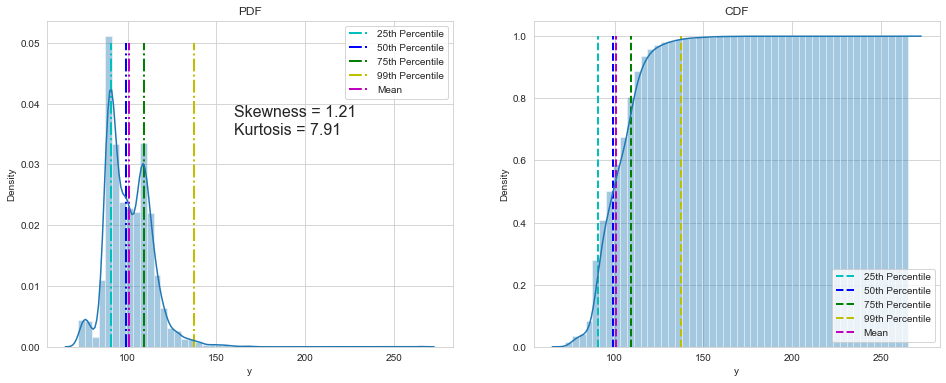

In [ ]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
sns.distplot(train.y)
plt.text(160, 0.035,
         f'Skewness = {round(train.y.skew(),2)}\nKurtosis = {round(train.y.kurtosis(),2)}',
         fontdict=dict(fontsize=16))
plt.vlines(percentile25, 0, .05, color='c', ls='-.', lw=2, label='25th Percentile')
plt.vlines(percentile50, 0, .05, color='b', ls='-.', lw=2, label='50th Percentile')
plt.vlines(percentile75, 0, .05, color='g', ls='-.', lw=2, label='75th Percentile')
plt.vlines(percentile99, 0, .05, color='y', ls='-.', lw=2, label='99th Percentile')
plt.vlines(mean        , 0, .05, color='m', ls='-.', lw=2, label='Mean')
plt.title('PDF')
plt.legend(loc="upper right")

plt.subplot(1,2,2)
sns.distplot(train.y, kde_kws={'cumulative': True}, hist_kws={'cumulative': True})
plt.vlines(percentile25, 0, 1, color='c', ls='--', lw=2, label='25th Percentile')
plt.vlines(percentile50, 0, 1, color='b', ls='--', lw=2, label='50th Percentile')
plt.vlines(percentile75, 0, 1, color='g', ls='--', lw=2, label='75th Percentile')
plt.vlines(percentile99, 0, 1, color='y', ls='--', lw=2, label='99th Percentile')
plt.vlines(mean        , 0, 1, color='m', ls='--', lw=2, label='Mean')
plt.title('CDF')
plt.legend(loc="lower right")


plt.show()

**Observation**

- The DIstribution is left skewed and has a long tail on the right side, indicated by the high values for Skewness and Kurtosis
- The PDF and CDF for the Target Variable 'y'
- The PDF has a long tail on the right which means there are few samples that have extremely large test time.
- These samples could affect the model training
- It can also be seen that there is a huge gap between 99 percentile and 10 percentile value, which also confirms the presence of few outliers in the data
- Also peaks can be seen in the distribution at various values of 'y' which indicate multimodal distribution of test time
- This is an indication of presence of gropus of simialar configurations and features that result in similar test-time.

In [ ]:
for i in range(90, 101, 1):
    percentile = np.round(np.percentile(train.y.tolist(), i), 4)
    print(f"{i} th Percentile \t: {percentile}")
print('\n', 35*'=', '\n')
for i in range(990, 1001, 1):
    i /= 10
    percentile = np.round(np.percentile(train.y.tolist(), i), 4)
    print(f"{i} th Percentile \t: {percentile}")

90 th Percentile 	: 115.25
91 th Percentile 	: 116.0484
92 th Percentile 	: 116.8916
93 th Percentile 	: 118.0376
94 th Percentile 	: 119.056
95 th Percentile 	: 120.806
96 th Percentile 	: 122.4
97 th Percentile 	: 125.8932
98 th Percentile 	: 129.2992
99 th Percentile 	: 137.4304
100 th Percentile 	: 265.32


99.0 th Percentile 	: 137.4304
99.1 th Percentile 	: 139.0902
99.2 th Percentile 	: 140.1836
99.3 th Percentile 	: 140.8164
99.4 th Percentile 	: 142.648
99.5 th Percentile 	: 146.2304
99.6 th Percentile 	: 149.0374
99.7 th Percentile 	: 151.4277
99.8 th Percentile 	: 154.687
99.9 th Percentile 	: 160.3833
100.0 th Percentile 	: 265.32


- The long tail is mainly due to a single observation with very high Test time of 265 seconds.

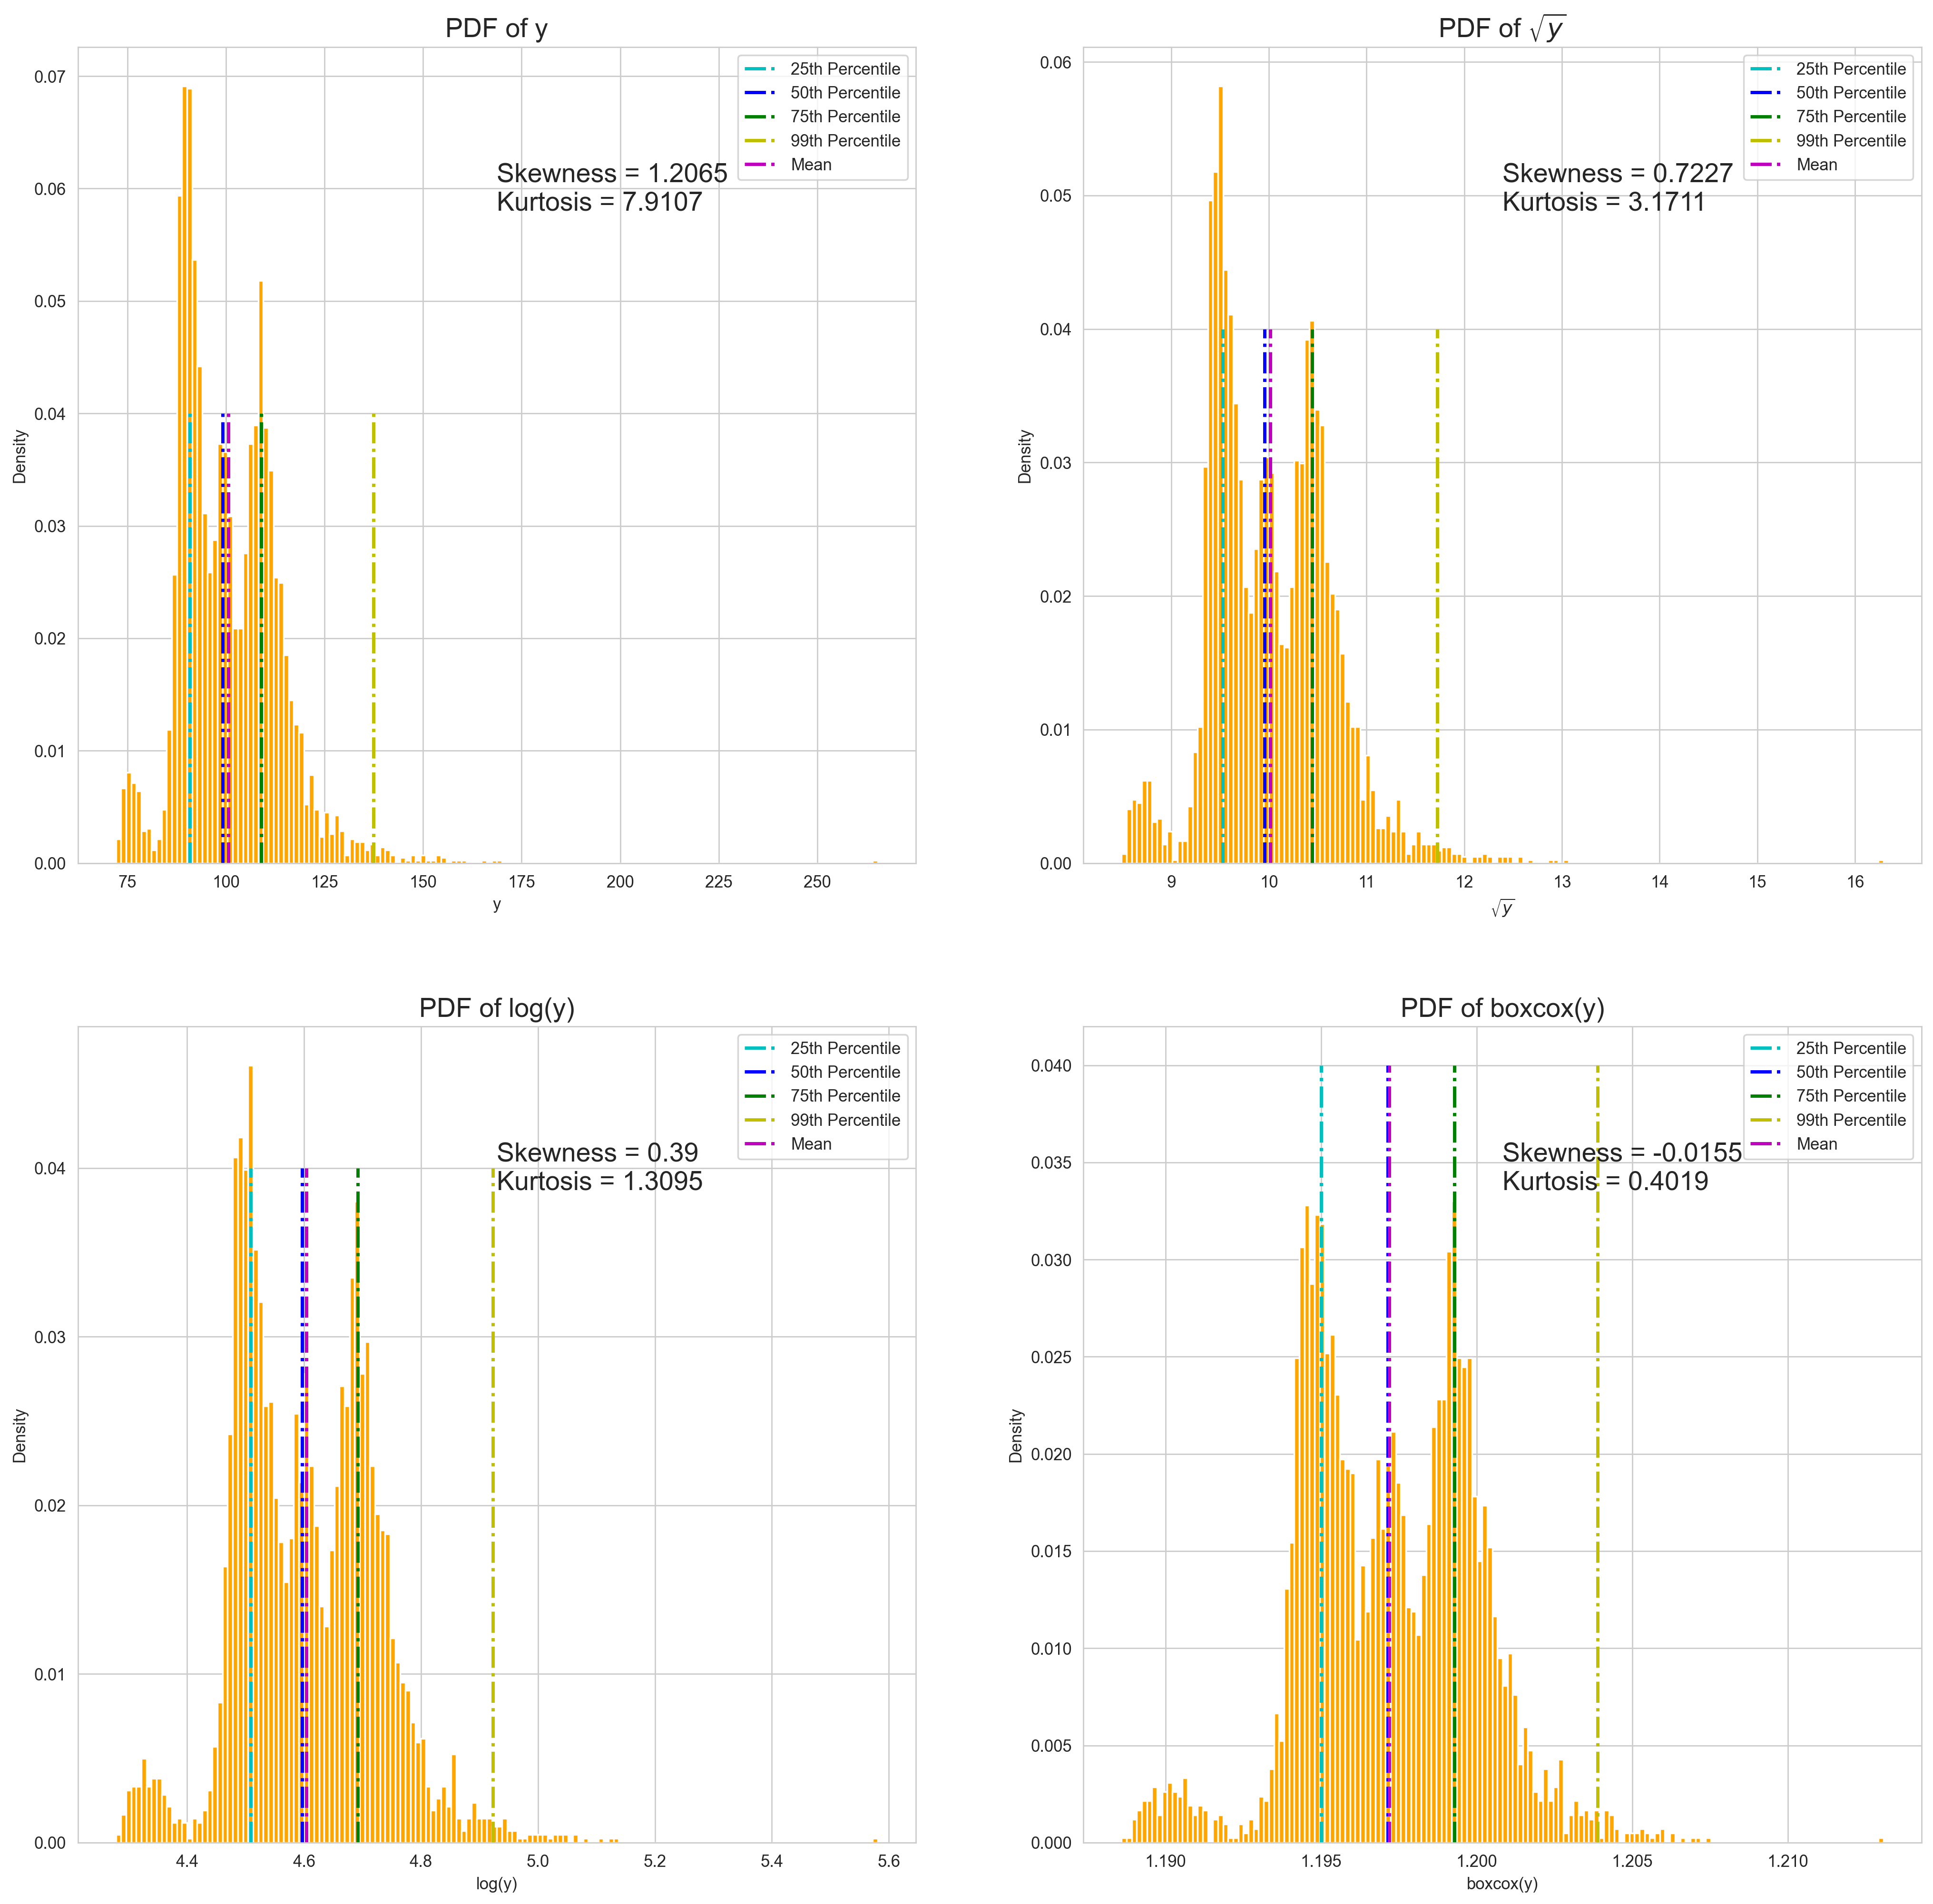

In [ ]:
y             = train.y
sqrt_y        = pd.Series(np.sqrt(y.values))
log_y         = pd.Series(np.log(y.values))
box_y, lamda  = pd.Series(boxcox(y.values)[0]), boxcox(y.values)[1]

ys     = [y, sqrt_y, log_y, box_y]
titles = ['PDF of y', 'PDF of $\sqrt{y}$', 'PDF of log(y)', 'PDF of boxcox(y)']
colors = ['c', 'b', 'g', 'y']
labels = ['25th Percentile', '50th Percentile', '75th Percentile', '99th Percentile']

plt.figure(figsize=(20,20), dpi=250)
for i in range(4):
    plt.subplot(2,2,i+1)
    weights = np.ones_like(ys[i].values)/float(len(ys[i].values))
    plt.hist(ys[i], weights=weights, bins=150, color='orange')
    for index, percentile in enumerate([25, 50, 75, 99]):
        p = np.percentile(ys[i], percentile)
        plt.vlines(p, 0,0.04, label=labels[index], color=colors[index], ls='-.', lw=2)
    plt.annotate(f'Skewness = {round(ys[i].skew(),4)}\nKurtosis = {round(ys[i].kurtosis(),4)}',
                 (0.5, 0.8),fontsize=16, xycoords='axes fraction')
    plt.vlines(ys[i].mean(), 0,0.04, label='Mean', color='m', ls='-.', lw=2)
    plt.ylabel('Density'); plt.xlabel(titles[i][7:])
    plt.title(titles[i], fontsize=16)
    plt.legend()  
plt.show()

**Observation**

- [Top 3 Methods for Handling Skewed Data](https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45)
- The first plot shows the distribution of our target variable 'y' along with the Skewness and Kurtosis values.
- Skewness is the measure of distortion from the symmetrical Bell Curve, used to differentiate extreme values on either side of the PDF
- Consider a random Variaable X with N samples, the Skewness for X is defined as 
$$
Skewness = \frac{1}{N} \sum_{i}^N [\frac{ (x_{i} - \bar{x})}{\sigma_{x}}]^3 
$$
- Here $\bar{x}$ is the mean of X


- Kurtosis is the measure of the tailedness of the distribution, it can be used to measure the outliers present in the data.
- Kurtosis is defined as
$$
    Kurtosis = \frac{1}{N} \sum_{i}^N [\frac{ (x_{i} - \bar{x})}{\sigma_{x}}]^4 
$$

- [Four moments of distribution: Mean, Variance, Skewness, and Kurtosis](http://learningeconometrics.blogspot.com/2016/09/four-moments-of-distribution-mean.html)

- The Skewness for Normal Distribution is 0
- The Kurtosis (Excess Kurtosis) for Normal Distribution is 0
- We applied 3 different types of transforms to reduce the effect of outliers on the model
- The first one was a simple **Square-root Transform** ($\sqrt{y}$)
    - This the simplest transform available to reduce the impact of outliers by scaling down the magnitude
    - The reverse transform will be quiet simple as well i.e. $[\sqrt{y}]^2$
    - We see a drastic improvement in skewness and kurtosis, however the values are still not ideal
    - **Skewness = 0.7277 | Kurtosis = 3.1711**
    
- The next transformation we applied was the **Log Transform** ($log(y)$)
    - This is also a monotonous transformation used to reduce the impact of outliers
    - The reverse transform is also straight forward i.e. $Antilog[log(y)]$
    - The skewness and Kurtosis has also imporved drastically compared to the square-root transformation
    - **Skewness = 0.39 | Kurtosis = 1.3095**

- The next transformation we applied was the **BoxCox Transform** ($\frac{x^\lambda - 1}{\lambda}$)
    - The value of $\lambda$ is found such that it maximizes the Log-Likelihood function
    - The reverse transform is 
        if $$ y = \frac{x^\lambda - 1}{\lambda}$$
        
        Then
        $$ x = (y * \lambda + 1)^\frac{1}{\lambda} $$
    - **Skewness = -0.0155 | Kurtosis = 0.4019**
  

In [ ]:
categorical_columns = list()
binary_columns      = list()
drop_columns        = list()

for col in train.columns:
    
    if   2 < train[col].nunique() < 50:
        categorical_columns.append(col)
        
    elif train[col].nunique() == 2:
        binary_columns.append(col)
        
    elif train[col].nunique() == 1:
        drop_columns.append(col)
      
    
print("\n These columns have only one category in the training data and hence can be ignored\n")
print(drop_columns, '\n')


 These columns have only one category in the training data and hence can be ignored

['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347'] 



- We're only considering columns which have atleast 2 states i.e. Binary features and categorical features.
- There were around 10-12 features with only one state throughout the train data, the test data may or may not contain the other states hence it is good to remove such columns
- The only continuous variables present are 'ID' and the target variable 'y'.
- We'll be applying the log transform on the data to correct for skewness and kurtosis.

### Removing Duplicates

- The dataset contains samples which have the same value for the input variables like X0, X1, .. X385, but with different test time. 
- This could be due to varius reasons, but it is hard to interpret those reasons due to the anonymous nature of the features
- These samples could result in contradictory conclusions by our model and hence need to be corrected.
- The test time for the duplicates can be replaced by mean of all the duplicates, i.e taking the mean of test time for samples with duplicate inputs.

In [ ]:
train = train.groupby(categorical_columns + binary_columns).mean().reset_index()

In [ ]:
X = train[categorical_columns + binary_columns]
y = train['y'].apply(lambda x: np.log(x))

## Encoding Categorical Variables

### Target Encoding

- Target encoding is when the categorical features are encoded with the mean of the target variable.
- This converts categorical columns to numeric and decreases the cardinality of the data.
- This helps the model as the categories are numeric, ordinal and hence more interpretable.

In [ ]:
target_encoder = ce.target_encoder.TargetEncoder(cols=categorical_columns)
target_encoder.fit(X, y)

X = target_encoder.transform(X)
print(X.shape)

(3911, 364)


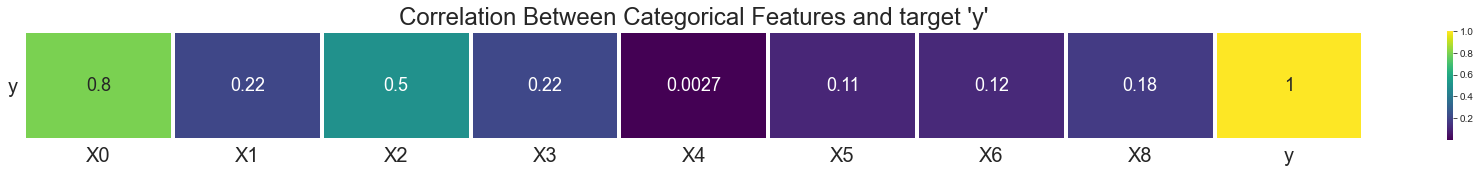

In [ ]:
temp_df = (pd.concat([X, y], axis=1))
fig, ax = plt.subplots(figsize=(30, 2))
sns.heatmap(temp_df[categorical_columns + ['y']].corr(method='pearson')[['y']].values.T, cmap='viridis', annot_kws=dict(fontsize=18), lw=3, annot=True, ax=ax)
ax.set_xticklabels(list(temp_df[categorical_columns + ['y']].columns), fontdict=dict(fontsize=20))
ax.set_yticklabels(['y'], fontdict=dict(fontsize=20), rotation=0)
plt.title("Correlation Between Categorical Features and target 'y'", fontsize=24)
plt.show()

**Observation**

- The Pearson's Correlation Coefficient is defined as 
$$
\text{Pearson's Correlation Coefficient} = \frac{\sum_{i}^N (x_{i} - \bar{x})(y_{i} - \bar{y})}{\sqrt{\sum_{i}^N (x_{i} - \bar{x})^2 \sum_{i}^N (y_{i} - \bar{y})^2}} = \frac{\text{Cov(X,Y)}}{\sigma_{x} * \sigma_{y}}
$$
- The figure shows the correlation coefficient between the Mean Encoded Categorical Features with the Target Variable 'y'.
- The feature X0 has the highest correlation with 'y' with a Person's Coefficient of 0.8, followed by the feature X2.

In [ ]:
# Reference: https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/discussion/34826
def gradient(diff: np.ndarray, delta: int =1) -> np.ndarray:
    '''
    Gradient for the Pseudo Huber Loss
    Inputs:
        diff  : Vector consisting of difference between Ground Truth of Target and the Predicted Target
        delta : Hyperparameter for the PseudoHuber Loss function. 
                The threshold within which the loss is quadratic in nature,
                outside the thresold the loss is linear
    Outputs:
        g     : Gradients for the PsedoHuber Loss
    '''
    g      = delta*diff*(np.power((delta**2 + diff**2),-1/2))
    return g

def hessian(diff: np.ndarray, delta: int =1) -> np.ndarray:
    '''
    Hessian for the Pseudo Huber Loss
    Inputs:
        diff  : Vector consisting of difference between Ground Truth of Target and the Predicted Target
        delta : Hyperparameter for the PseudoHuber Loss function. 
                The threshold within which the loss is quadratic in nature,
                outside the thresold the loss is linear
    Outputs:
        h     : Hessian for the PsedoHuber Loss
    '''
    h      = delta**3*(np.power((delta**2 + diff**2),-3/2))
    return h

def PseudoHuberLoss(y_true: np.ndarray , y_pred: np.ndarray, delta: int =1) -> (np.ndarray, np.ndarray):
    '''
    Gradient & Hessian for the Pseudo Huber Loss
    Inputs:
        y_true: Ground truth for target
        y_pred: Predicted target
        delta : Hyperparameter for the PseudoHuber Loss function. 
                The threshold within which the loss is quadratic in nature,
                outside the thresold the loss is linear
    Outputs:
        g     : Gradients for the PsedoHuber Loss
        h     : Hessian for the PsedoHuber Loss
    '''
    y_pred = y_pred.ravel()
    diff   = y_pred - y_true
    g      = gradient(diff, delta=delta)
    h      = hessian(diff, delta=delta)
    return g,h

R2_score = make_scorer(r2_score, greater_is_better=True)

**Pseudo Huber Loss**

- [Reference](https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/discussion/34826)
- Due to the presence of outliers in the data, I've decided to use a more robust loss function in the Recursive Feature Elimination process performed using the XGBoost Regressor Model
- Huber Loss is a robust loss function used in regression that is less sensitive to outliers than Squared Loss.
- The Huber loss is defined as

$$
\text{Huber Loss} = \left\{\begin{array}{lr}
        \frac{1}{2}(y - f(x))^2 & \text{for } |y - f(x)|\leq \delta,\\
        \delta (y - f(x)) - \frac{1}{2}\delta^2 & \text{otherwise }\\
        \end{array}\right\} 
$$

- $\delta$ is a hyperparameter for this loss, it defines the region or the threshold inside which the loss is quadratic outside which the loss is linear.

- However this function is discontinuous at $\delta$ and hence not differentiable at delta.
- Instead a smooth approximation of it is used generally called as the Pseudo Huber Loss
- Pseudo Huber Loss is defined as

$$
\text{Pseudo Huber Loss} =  \delta \sqrt{\delta^2 + (y - f(x))^2} - \delta^2
$$

- The derivatives for Huber Loss
$$
\text{Gradient} = \frac{\delta * (y - f(x))}{(\delta^2 + (y - f(x))^2)^{1/2}}
$$

[Reference](https://socratic.org/questions/how-do-you-differentiate-y-sqrt-1-x-2)

$$
\text{Hessian} = \frac{\delta^3}{(\delta^2 + (y - f(x))^2)^{3/2}}
$$

[Reference](https://socratic.org/questions/how-do-you-find-the-derivative-of-x-sqrt-x-2-1)

**Note:** The optimizer for XGBoost Regressor doesn't actually require the Loss, only the gradients for calculating the updates.

### Recursive Feature Selection

In [ ]:
est = XGBRegressor(max_depth=3, n_estimators=1000, base_score=y.mean(), objective=PseudoHuberLoss, seed=100, random_state=0)
rfecv = RFECV(estimator=est, step=1, cv=2, verbose=0, n_jobs=2, scoring=R2_score)
rfecv.fit(X, y)

Optimal number of features : 3


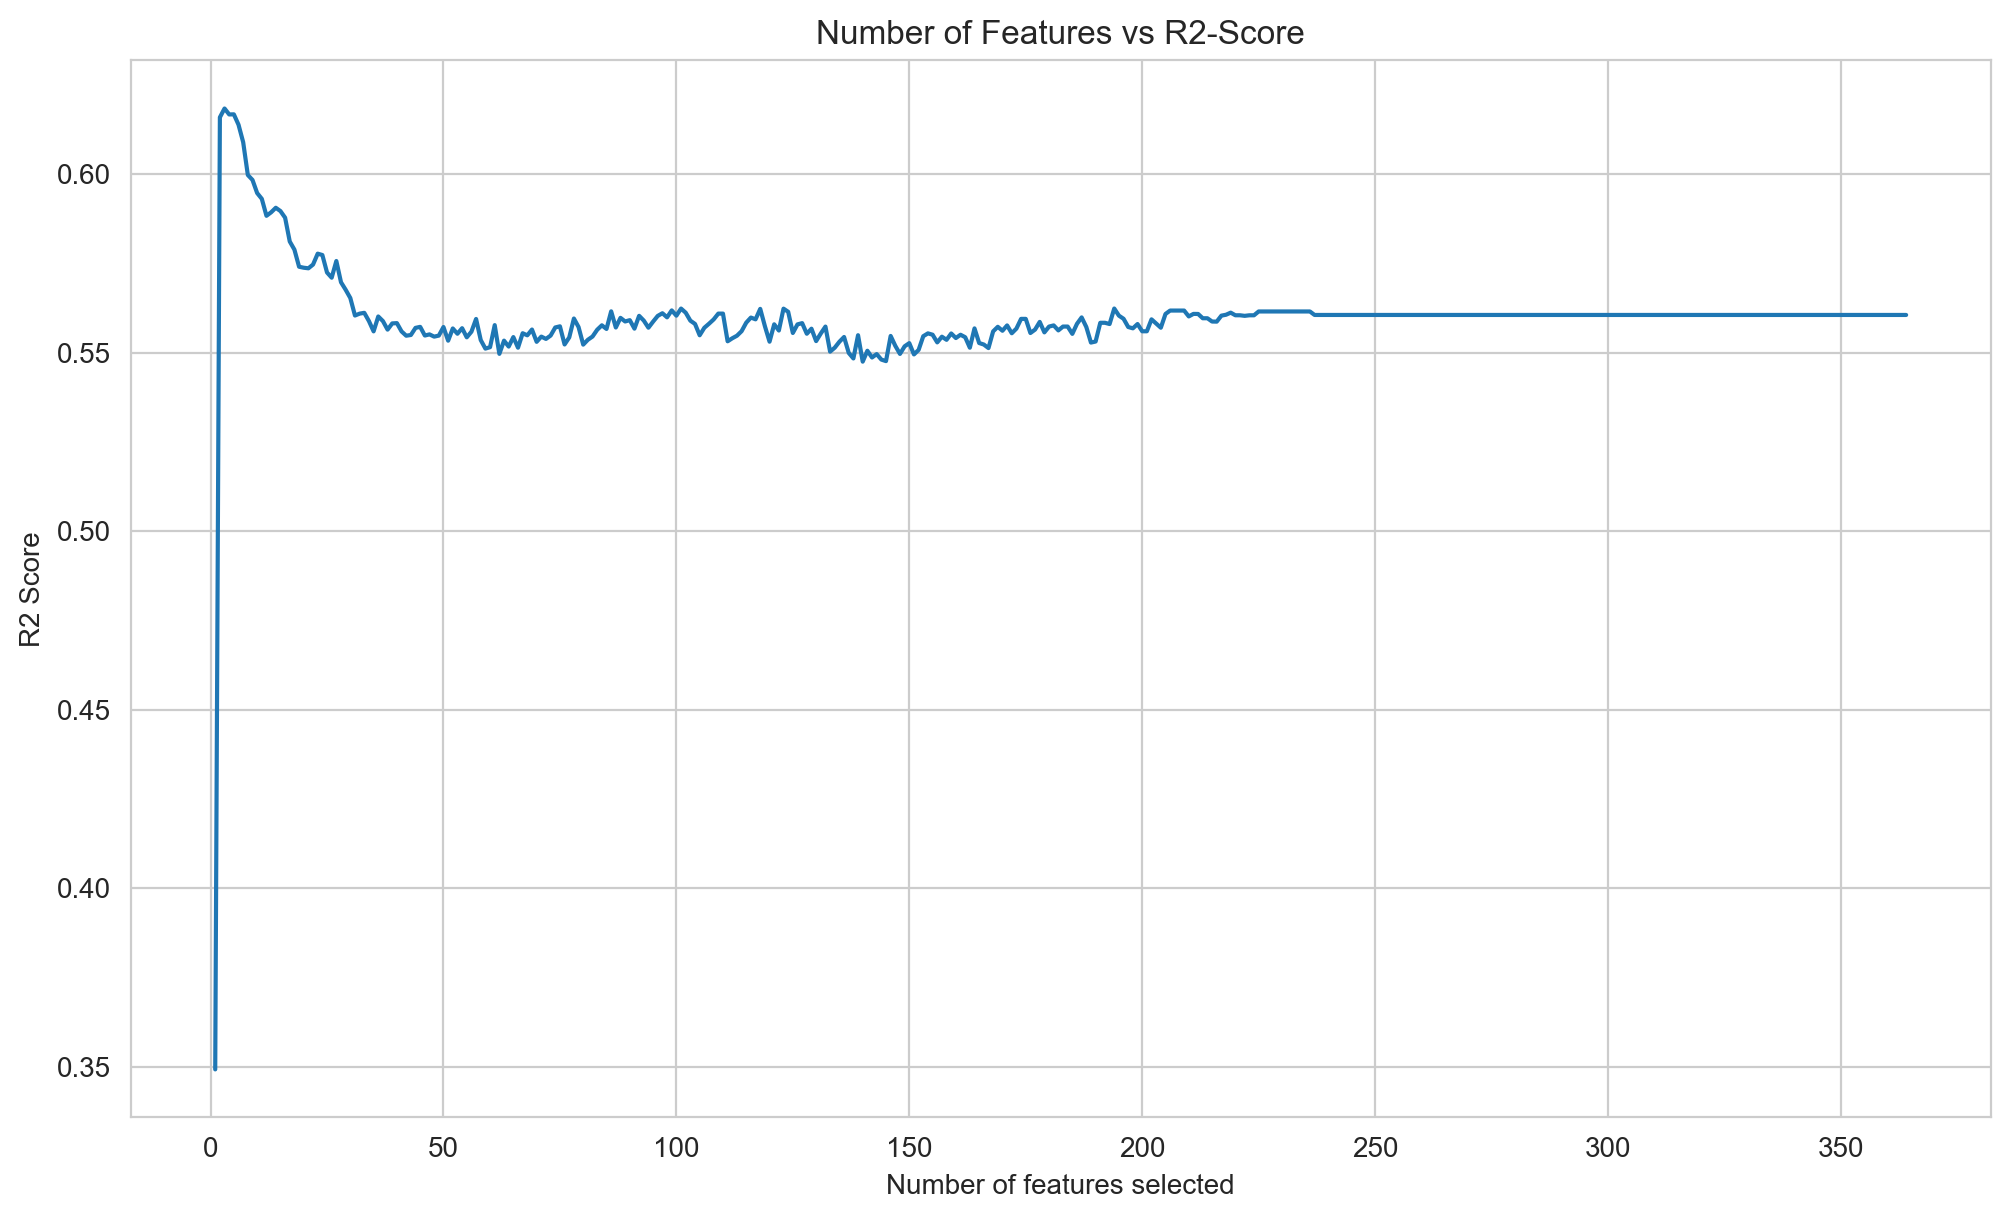

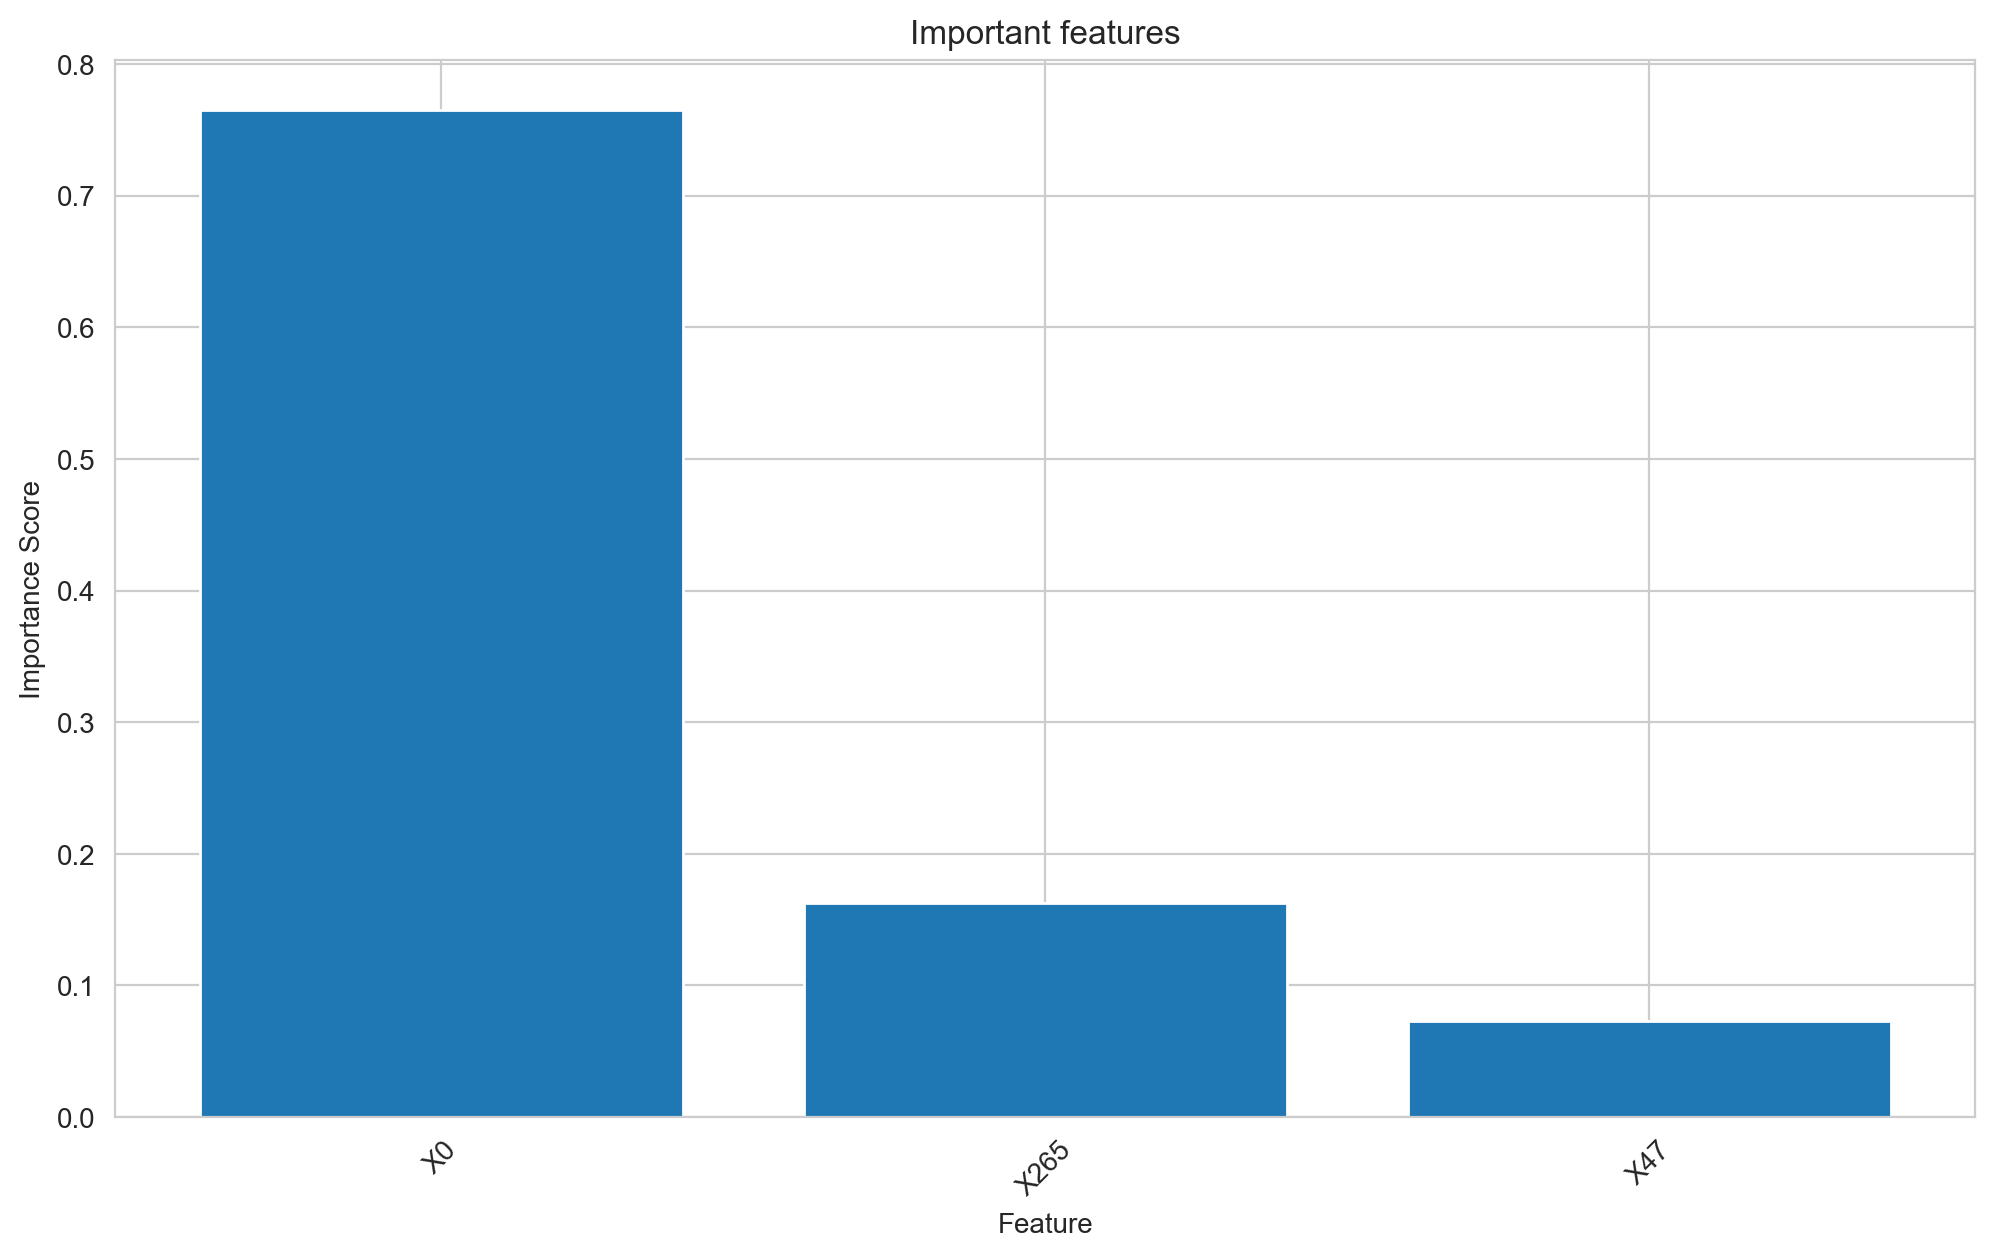

In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(12,7), dpi=200)
plt.xlabel("Number of features selected")
plt.ylabel("R2 Score")
plt.title('Number of Features vs R2-Score')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

imp_col_indices = rfecv.get_support(indices=True)
imp_col_names   = list(X.columns[imp_col_indices])
imp_col_scores  = list(rfecv.estimator_.feature_importances_)

zipped = zip(imp_col_names, imp_col_scores)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)

sorted_col_names, sorted_col_scores = zip(*zipped)
sorted_col_names, sorted_col_scores = list(sorted_col_names), list(sorted_col_scores) 
fig, ax = plt.subplots(figsize=(12,7), dpi=200)
ax.bar(sorted_col_names, sorted_col_scores)
ax.set_title('Important features')
ax.set_xticklabels(sorted_col_names, rotation=45)
ax.set_xlabel('Feature'); ax.set_ylabel('Importance Score')
plt.show()

**Observation**

- There were around 364 features to select from, the Recursive Feature Elimination through Cross Validation has resulted in selection of just 3 important features out of the 364 features.
- As seen previously from the correlation plot, the feature 'X0' has the most amount of interaction with the target variable 'y'.
- The Feature X0 has 47 uniques categories in the training data, a further look into these categories will help extract more information.
- The importance score for 'X0' is significantly higher than the score for feature 'X265' and 'X47'.
- Features X265 and X47 are Binary Features, Binary Features also need a closer look for extracting more information.

### 3.2 Categorical Features

### Feature X0

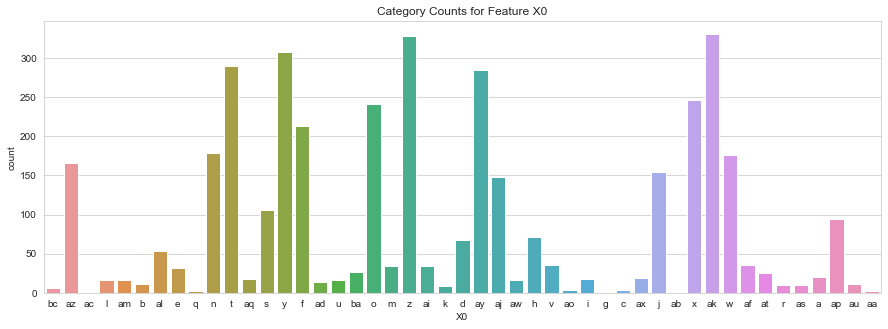

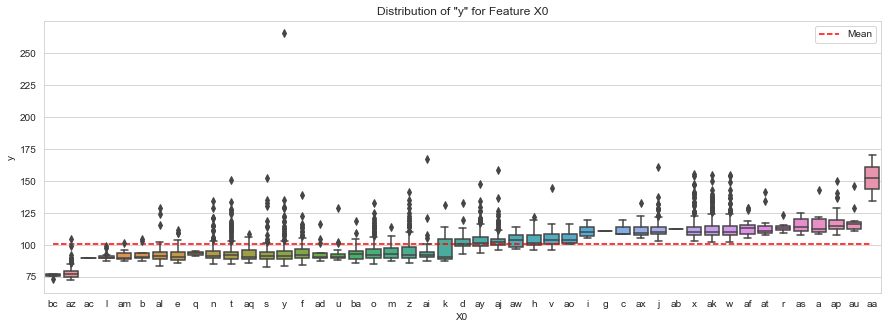

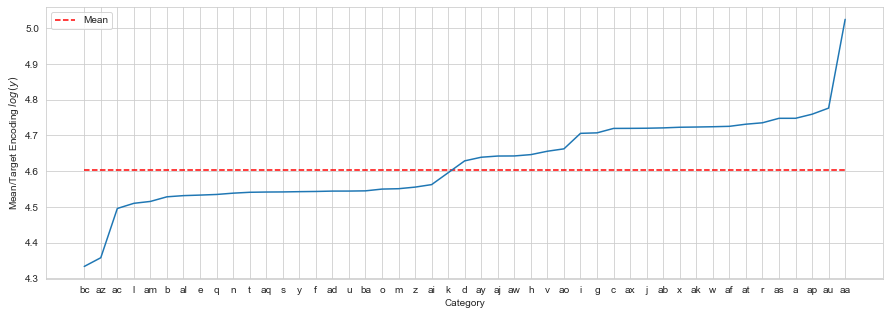

In [ ]:
col, target = 'X0', 'y'
df = train
mean_order = df.groupby(col).mean()[target].sort_values().index
plt.figure(figsize=(15,5))
sns.countplot(data=df, x=col, order=mean_order) 
plt.title(f'Category Counts for Feature {col}')
plt.show()
    
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x=col, y=target, order=mean_order)
plt.hlines(df[target].mean(), 0, df[col].nunique()-1, color='r', ls='--', label="Mean")
plt.title(f'Distribution of "{target}" for Feature {col}')
plt.legend();plt.show()
    
plt.figure(figsize=(15,5))
plt.plot(mean_order, np.log(df.groupby(col).mean()[target].sort_values().values))
plt.hlines(y.mean(), 0, df[col].nunique()-1, color='r', ls='--', label="Mean")
plt.xlabel('Category'); plt.ylabel('Mean/Target Encoding $log(y)$')
plt.legend();plt.show()

**Observation**

- The categories aren't distributed uniformly for feature X0
- Categories with high count have higher number of outliers.
- The Categories seem to be ordinal i.e. they seem to have some sort of inherent order in them.
- The categories from feature 'X0' have the most amount of interaction with the target 'y'
- When the categories are mean encoded, a monotonously increasing correlation can be seen between the categories of X0 and our target 'y'.
- The samples belonging to the categories of 'bc' and 'az' are responsible for the peaks at the lower end of the distribution for 'y'.
- The test time for categories 'bc' and 'az' belong to the lower end of the range for 'y' between 4.3 - 4.5. Whereas the test time for category 'aa' belongs to the higher end of the range for 'y' around 4.8 - 5.0
- Other categories are tightly bound in the range of 4.5 - 4.8 for $log(y)$.

### 3.3 Binary Features

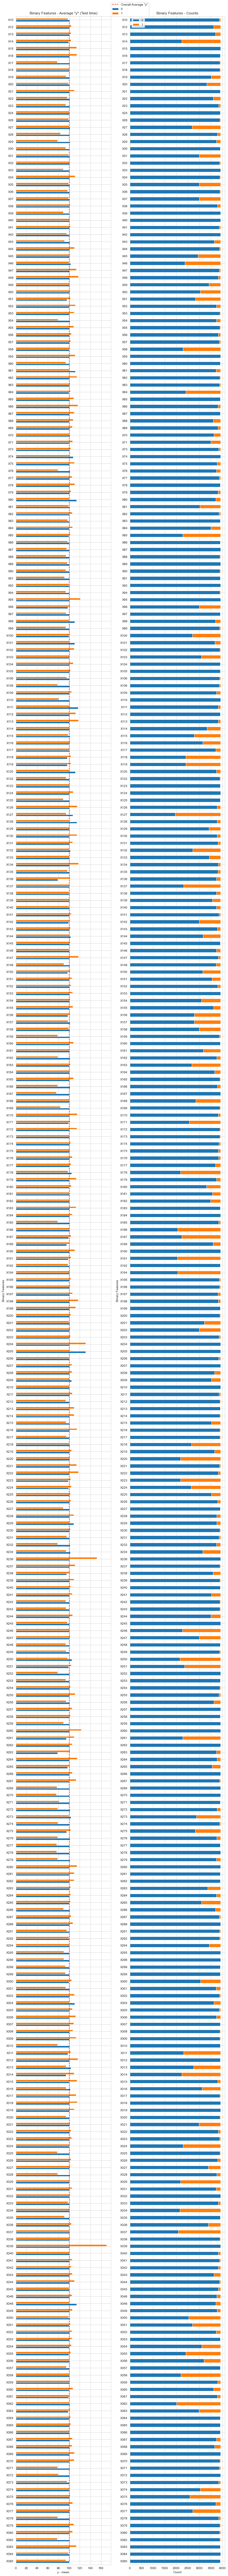

In [ ]:
counts_0, counts_1 = list(), list()
means_0 ,  means_1 = list(), list()

for col in binary_columns:
    count_0, count_1 = train[col].value_counts().values
    mean_0,  mean_1  = train.groupby(col).mean()['y'].values
    counts_0.append(count_0); means_0.append(mean_0)
    counts_1.append(count_1); means_1.append(mean_1)

df1 = pd.DataFrame()
df1['Binary Features'] = binary_columns[::-1]
df1['0'] = means_0[::-1]
df1['1'] = means_1[::-1]
df1.index = df1['Binary Features']
df1 = df1.drop(columns=['Binary Features'])

df2 = pd.DataFrame()
df2['Binary Features'] = binary_columns[::-1]
df2['0'] = counts_0[::-1]
df2['1'] = counts_1[::-1]
df2.index = df2['Binary Features']
df2 = df2.drop(columns=['Binary Features'])

fig, ax = plt.subplots(nrows=1, ncols=2)
df1.plot(kind='barh', ax=ax[0], figsize=(12, 150))
ax[0].vlines(mean, 0, len(binary_columns)-1, color='r', ls='--', label='Overall Average "y"')
ax[0].set_title('Binary Features - Average "y" (Test time)')
ax[0].set_xlabel('y - mean')
ax[0].legend(loc=(1,1))

df2.plot(kind='barh', stacked=True, ax=ax[1], figsize=(12, 150))
ax[1].set_title('Binary Features - Counts')
ax[1].set_xlabel('Count')
plt.show()

**Observation**

- There are around 356 Binary features in the dataset
- On the left there is the mean test time for 1 and 0 labels respectively for each feature
- On the right  there is the count for 1 and 0 labels respectively for each feature
- The mean test time for each binary feature is close to the overal average test time, but the features which have very high or very low mean test time usually have highly unbalanced distribution for classes 0 and 1
- Majority of the features have a mean close to 100 sec
- Features X127 and X314 have quiet a bit of deviation from the overall avegrage with a balance in both 0 and 1 class.

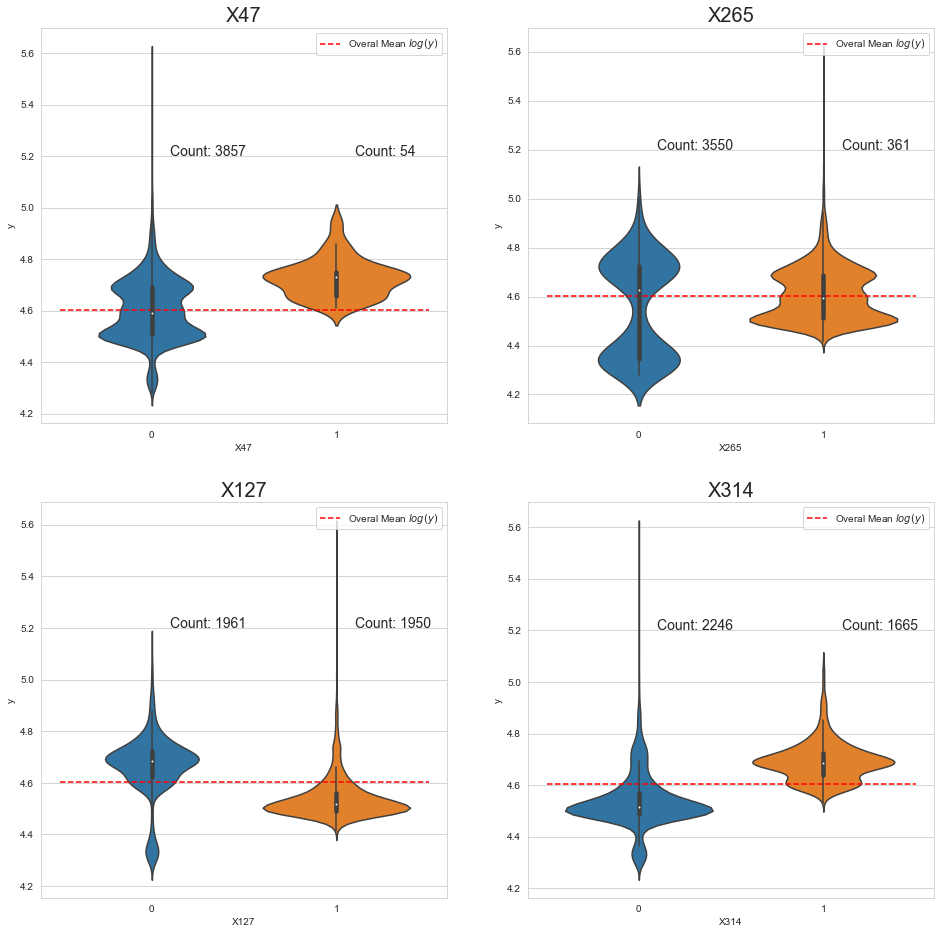

In [ ]:
imp_bin_cols = ['X47', 'X265']
imp_bin_cols.extend(['X127', 'X314'])

plt.figure(figsize=(16,16))
for i, col in enumerate(imp_bin_cols, 1):
    counts = train[col].value_counts().values
    plt.subplot(2,2,i)
    sns.violinplot(x=col, y='y', split=True, data=pd.concat([X,y], axis=1))
    plt.text(0.1, 5.2, "Count: "+str(counts[0]), fontdict=dict(fontsize=14))
    plt.text(1.1, 5.2, "Count: "+str(counts[1]), fontdict=dict(fontsize=14))
    plt.hlines(y.mean(), -0.5, 1.5, color='r', ls='--', label='Overal Mean $log(y)$')
    plt.legend(); plt.title(col.upper(), fontsize=20)
plt.show()

**Observation**

- The plot shows distribution for Binary features with respect to the target variable "y".
- Features X47 and X265 have multiple peaks in the distribution.
- When X47 = 1, the test time is greater than the mean test time. This feature is a good indicator for samples with test time in the upper range of the data.
- The two peaks in the distribution indicate a bimodal distribution for feature X265.
- The multimodal nature of the plots indicate groups of similar features or configurations that result in similar test time.
- The peaks for features X127 and X314 are much more clearly seperable by the mean line.
- These features will be a good for seperating the bimodal distribution of the test time.

### Bivariate Analysis

In [ ]:
def interaction_plot(col1: str, col2: str) -> None:
    '''
    Plots a Violin Plot with a given hue
    Inputs:
        col1   : Feature on Y-axis
        col2   : Feature used as Hue
    Ouptputs:
        returns: None
        plots the violin plot
    '''
    ax = sns.violinplot(x="y", y=col1, hue=col2, orient='h', split=True, data=pd.concat([X, y], axis=1))#  kind="violin", height=5, data=pd.concat([X, y], axis=1))
    ax.vlines(y.mean(), -0.5, 1.5, color='r', ls='--', label="Overall Mean $log(y)$")
    ax.set_xlabel("$log(y)$")
    ax.legend(loc="lower right", title=col2)
    ax.set_title(f"({col1} & {col2}) vs $log(y)$")

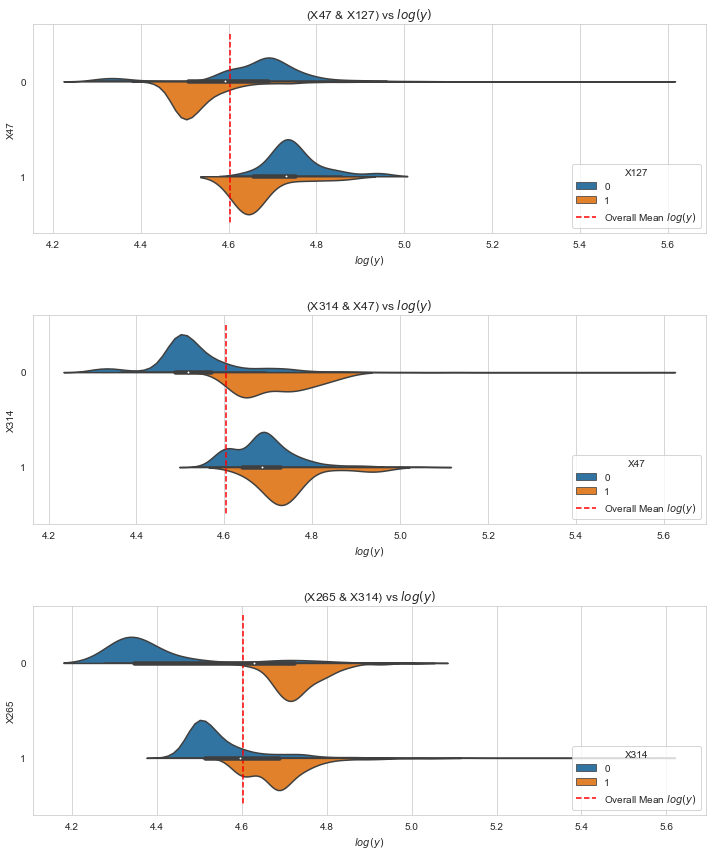

In [ ]:
plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
interaction_plot("X47", "X127")

plt.subplot(3,1,2)
interaction_plot("X314", "X47")

plt.subplot(3,1,3)
interaction_plot("X265", "X314")

plt.tight_layout(h_pad=3)

**Observation**

- The distribution plots for feature interaction between various selected features.
- The seperation between the peaks of the distribution allows for interesting feature interactions.
- When X47 = 0, the value for feature X127 has a correlation to the test time, i.e if X127 = 0, the test time is generally higher than the mean, whereas if X127 = 1, the test time is generally lower than the mean test time 'y'.
- A similar trend is observed when X47 = 1, however the test time for both X127 = 0 & X127 = 1 are generally higher than the mean test time 'y'.
- Similarly for feature X314 = 0, the value for feature X47 has a correlation to the test time, i.e if X47 = 0, the test time is generally lower than the mean, whereas if X47 = 1, the test time is generally higher than the mean.
- Similarly for feature X265 = 0, the value for feature X47 has a correlation to the test time, i.e if X314 = 0, the test time is generally lower than the mean, whereas if X314 = 1, the test time is generally higher than the mean.
- For feature X265 the difference between the two distributions is a lot more pronounced.
- Even when X265 = 1, the same trend is observed.

In [ ]:
mapping = {key:value for key, value in zip(list(train['X0'].unique()), list(target_encoder.mapping.get("X0"))[:-2])}
reverse_mapping = {value:key for key, value in zip(list(train['X0'].unique()), list(target_encoder.mapping.get("X0"))[:-2])}
reverse_mapping[mapping.get('ab')] = 'ab,\nac,\ng'

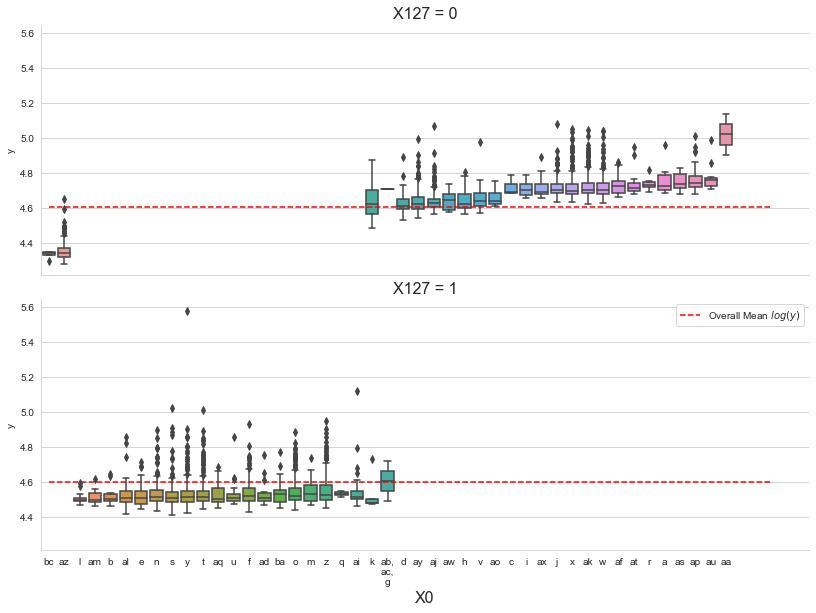

In [ ]:
col = "X127"
g = sns.catplot(y="y", x="X0", row=col, kind="box", orient="v", height=4, aspect=3, data=pd.concat([X, y], axis=1))
    
ax1, ax2 = g.axes[:,0]
xticks = list(ax2.get_xticklabels())
xticks = list(map(lambda x: float(x.get_text()), xticks))
xticks = list(map(lambda x: reverse_mapping.get(x), xticks))
    
ax1.set_title(f"{col} = 0", fontsize=16)
ax2.set_title(f"{col} = 1", fontsize=16)
ax2.set_xticklabels(xticks, rotation=0)
ax2.set_xlabel("X0", fontsize=16)
    
ax1.hlines(y.mean(), 0, 47, color='r', ls='--', label="Overall Mean $log(y)$")
ax2.hlines(y.mean(), 0, 47, color='r', ls='--', label="Overall Mean $log(y)$")
plt.legend()
plt.show()

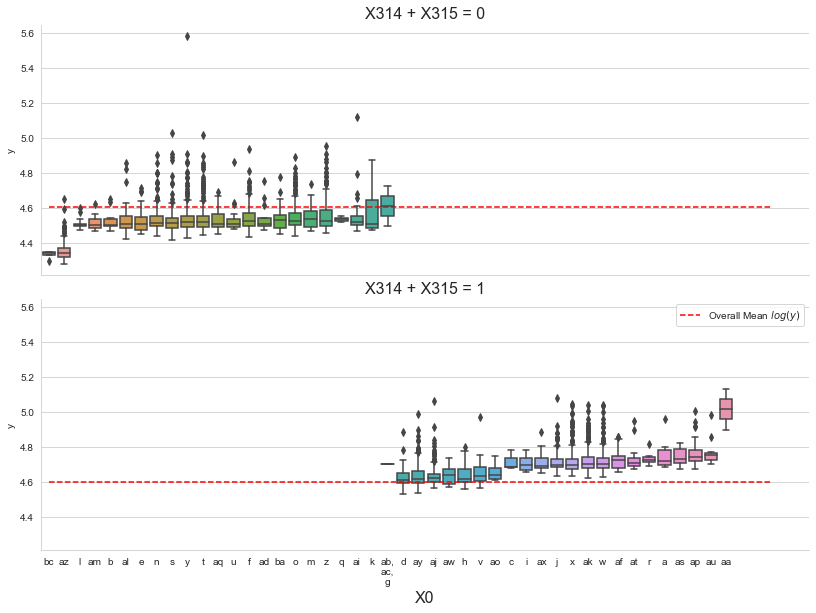

In [ ]:
X["X314 + X315"] = X["X314"] + X["X315"]
col = "X314 + X315"
g = sns.catplot(y="y", x="X0", row=col, kind="box", orient="v", height=4, aspect=3, data=pd.concat([X, y], axis=1))
    
ax1, ax2 = g.axes[:,0]
xticks = list(ax2.get_xticklabels())
xticks = list(map(lambda x: float(x.get_text()), xticks))
xticks = list(map(lambda x: reverse_mapping.get(x), xticks))
    
ax1.set_title(f"{col} = 0", fontsize=16)
ax2.set_title(f"{col} = 1", fontsize=16)
ax2.set_xticklabels(xticks, rotation=0)
ax2.set_xlabel("X0", fontsize=16)
    
ax1.hlines(y.mean(), 0, 47, color='r', ls='--', label="Overall Mean $log(y)$")
ax2.hlines(y.mean(), 0, 47, color='r', ls='--', label="Overall Mean $log(y)$")
plt.legend()
plt.show()

**Observation**

- The most interesting feature interaction is between the Features X0 and X127.
- The feature X127 creates two seperate groups of configurations for the categories in X0
- The seperation can be clearly seen in the plot above.
- The categories 'ab', 'ac', and 'g' have been merged together since they have the same exact mean.
- This could carry some inherent meaning about the type of test or the combination of configurations in the testing used.
- Also it would allow us to bin certain categories to ceratin ranges, this could help in reducing the cardinality of the data.
- However we could loose information while binning, hence Mean Encoding would be a better approach to reduce cardinality of the data.

In [ ]:
ranges = ["70 - 80", "80 - 100", "90 - 110", "100 - 120", ">120"]
categories = ["bc, az", "l, am, b, e, al, n, s, t, y, aq, u, f, ad, ba, o, m, z, q, ai", "k, ab, ac, g, d, ay", "aw, aj, h, v, ao, c, i, j, ax, x, ak, w, af, at, r, as, a, ap", "aa"]

range_cat = pd.DataFrame()
range_cat['X0 Categories'] = categories
range_cat['Range for test-time (y) in seconds'] = ranges

print(tabulate(range_cat, headers="keys", showindex=False, tablefmt="fancy_grid"))

╒═══════════════════════════════════════════════════════════════╤══════════════════════════════════════╕
│ X0 Categories                                                 │ Range for test-time (y) in seconds   │
╞═══════════════════════════════════════════════════════════════╪══════════════════════════════════════╡
│ bc, az                                                        │ 70 - 80                              │
├───────────────────────────────────────────────────────────────┼──────────────────────────────────────┤
│ l, am, b, e, al, n, s, t, y, aq, u, f, ad, ba, o, m, z, q, ai │ 80 - 100                             │
├───────────────────────────────────────────────────────────────┼──────────────────────────────────────┤
│ k, ab, ac, g, d, ay                                           │ 90 - 110                             │
├───────────────────────────────────────────────────────────────┼──────────────────────────────────────┤
│ aw, aj, h, v, ao, c, i, j, ax, x, ak, w, af, at, r, a

- The Categories can roughly be binned into these ranges, if we ignore the per category outlier samples.

### EDA: Conclusion

- The Dataset contains 7 Categorical Features, 356 Binary Features, 1 Continuous Feature and 1 continuous Target variable
- The Dataset has no missing or Nan values
- The distribution of y showed a heavily tailed one, presence of outliers was suspected.
- A log transformhas been applied to the target variable to correct the skewness and the tailedness in its distribution.
- Recursive feature Elimination, resulted in 3 important features -> X0, X265 and X47.
- Other forms of visualization the Binary features do not have very good variance as a whole but few of them could be useful and important features like X127 and X314.
- Feature X0 is the most important feature in the task, it is highly correlated with the target variable
- The X0 categories can be binned together with the help of the target variable as shown above.

## Train Test Split

In [ ]:
from xgboost                   import XGBRegressor
from sklearn.model_selection   import train_test_split
from sklearn.metrics           import r2_score, mean_squared_error, make_scorer
from sklearn.preprocessing     import StandardScaler
from sklearn.neighbors         import KNeighborsRegressor
from sklearn.tree              import DecisionTreeRegressor
from sklearn.ensemble          import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.linear_model      import LinearRegression, SGDRegressor, LassoLarsCV, RidgeCV
from scipy.stats               import uniform, norm, loguniform
from sklearn.model_selection   import train_test_split, RandomizedSearchCV, GridSearchCV, PredefinedSplit
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.decomposition     import PCA, FastICA, TruncatedSVD
from sklearn.externals         import joblib

# Projections

- There are a lot of features in the dataset, however many features don't have any influence over the target variable.
- Its difficult to know of all the interactions possible between the features that would have an impact on the target variable.
- One way to overcome this problem is to apply dimensionality reduction techniques to the features.
- Dimensionality reduction is different from Feature selection, since the reduced dimensions are a combination of different existing features instead of being a single feature.
- Differernt methods of Dimensionality Reduction used in this case study:  
    - **Principal Component Analysis (PCA):** Aims to find the directions of maximum variance in high-dimensional data and projects it onto a new subspace with equal or fewer dimensions than the original one.  
    - **Independent Component Analysis (ICA):** is a computational method for separating a multivariate signal into additive subcomponents. This is done by assuming that the subcomponents are non-Gaussian signals and that they are statistically independent from each other.   
    - **Truncated Singular Value Decomposition (TSVD):** This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently.    
    - **Gaussian Random Projection (GRP):** In random projection, the original d-dimensional data is projected to a k-dimensional (k << d) subspace, using a random ${\displaystyle k\times d}{\displaystyle k\times d}$ - dimensional matrix R whose columns have unit lengths. Using matrix notation: If ${\displaystyle X_{d\times N}}{\displaystyle X_{d\times N}}$ is the original set of N d-dimensional observations, then ${\displaystyle X_{k\times N}^{RP}=R_{k\times d}X_{d\times N}}{\displaystyle X_{k\times N}^{RP}=R_{k\times d}X_{d\times N}}$ is the projection of the data onto a lower k-dimensional subspace. Random projection is computationally simple: form the random matrix "R" and project the ${\displaystyle d\times N}{\displaystyle d\times N}$ data matrix X onto K dimensions of order ${\displaystyle O(dkN)}{\displaystyle O(dkN)}$. If the data matrix X is sparse with about c nonzero entries per column, then the complexity of this operation is of order ${\displaystyle O(ckN)}{\displaystyle O(ckN)}$. In Gaussian random projection, the random matrix R can be generated using a Gaussian distribution.  
    - **Sparse Random Projection (SRP):** Sparse random matrix is an alternative to dense random projection matrix that guarantees similar embedding quality while being much more memory efficient and allowing faster computation of the projected data.  

In [ ]:
train = pd.read_csv('train.csv')
train = train.groupby(categorical_columns+binary_columns).mean().reset_index()
if ("X314 + X315" not in train.columns):
    train["X314 + X315"] = train["X314"] + train["X315"]
    binary_columns.append("X314 + X315")
X = train[categorical_columns + binary_columns]
y = train['y'].values

target_encoder = ce.target_encoder.TargetEncoder(cols=categorical_columns + binary_columns)
target_encoder.fit(X, y)

X = target_encoder.transform(X)

scaler = StandardScaler()
scaler.fit(X)

X = pd.DataFrame(scaler.transform(X), columns=categorical_columns + binary_columns)

n_comp = len(categorical_columns + binary_columns) - 1

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca_train = pca.fit_transform(X)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica_train = ica.fit_transform(X)

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_train = tsvd.fit_transform(X)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_train = grp.fit_transform(X)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_train = srp.fit_transform(X)

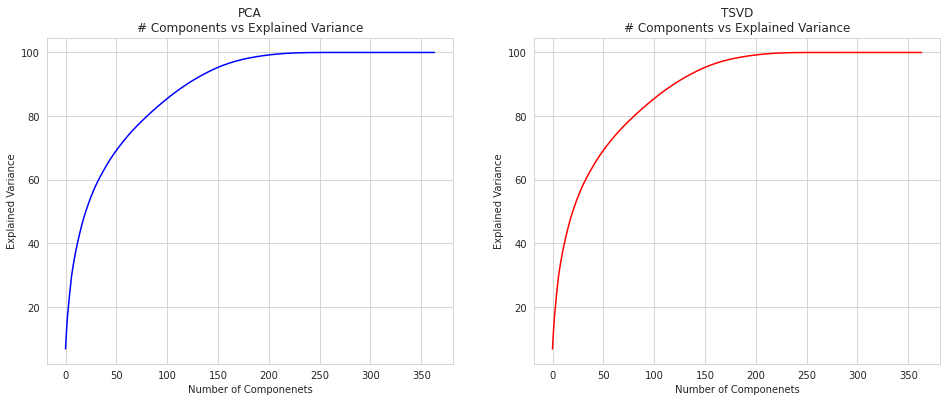

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(range(len(pca.explained_variance_)), np.cumsum(pca.explained_variance_)*100/np.sum(pca.explained_variance_), color='b', label="PCA")
plt.xlabel("Number of Componenets"); plt.ylabel("Explained Variance"); plt.title("PCA\n# Components vs Explained Variance")
plt.subplot(1,2,2)
plt.plot(range(len(tsvd.explained_variance_)), np.cumsum(tsvd.explained_variance_)*100/np.sum(tsvd.explained_variance_), color='r', label="TSVD")
plt.xlabel("Number of Componenets"); plt.ylabel("Explained Variance"); plt.title("TSVD\n# Components vs Explained Variance")
plt.show()

In [ ]:
scores = dict()
n = 10 # For 10 fold Validation
for n_comp in range(1,21):
    X_copy, y_copy = X.copy(), y.copy()
    for i in range(1, n_comp + 1):
        X_copy['pca_' + str(i)]  = pca_train[:, i - 1]
        X_copy['ica_' + str(i)]  = ica_train[:, i - 1]
        X_copy['tsvd_' + str(i)] = tsvd_train[:, i - 1]
        X_copy['grp_' + str(i)]  = grp_train[:, i - 1]
        X_copy['srp_' + str(i)]  = srp_train[:, i - 1]
        
    for _ in range(n):
        X_train, X_val, y_train, y_val = train_test_split(X_copy, y_copy, test_size=0.4)
        est = XGBRegressor(max_depth=3, n_estimators=1000, base_score=np.mean(y_train), objective=PseudoHuberLoss, seed=100, random_state=0)
        est.fit(X_train, y_train)
        y_pred = est.predict(X_val)
        score = r2_score(y_val, y_pred)
        if "n_comp = " + str(n_comp) not in scores.keys(): 
            scores["n_comp = " + str(n_comp)] = score/n
        else:                         
            scores["n_comp = " + str(n_comp)] += score/n

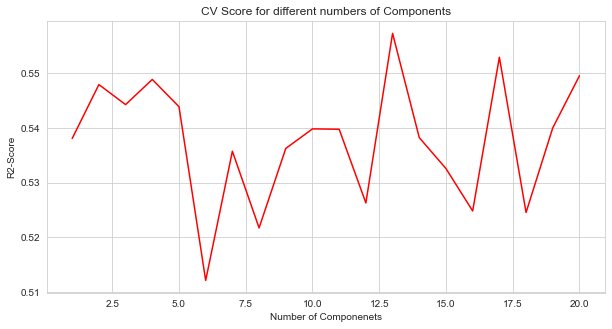

Number of components and respective 10-Fold CV R2-Score.


{'n_comp = 1': 0.5380794135888809,
 'n_comp = 2': 0.5479353588282705,
 'n_comp = 3': 0.5442717218746553,
 'n_comp = 4': 0.5488775725915123,
 'n_comp = 5': 0.5438889131577069,
 'n_comp = 6': 0.5121155125496478,
 'n_comp = 7': 0.535743507034251,
 'n_comp = 8': 0.5217286777067527,
 'n_comp = 9': 0.5362562046354554,
 'n_comp = 10': 0.5398332079090371,
 'n_comp = 11': 0.5397677440810535,
 'n_comp = 12': 0.5262931412535198,
 'n_comp = 13': 0.5573039222599282,
 'n_comp = 14': 0.5382325401379829,
 'n_comp = 15': 0.5325759306815677,
 'n_comp = 16': 0.5248241745116882,
 'n_comp = 17': 0.5529330232383955,
 'n_comp = 18': 0.5245435096024588,
 'n_comp = 19': 0.5400191558759025,
 'n_comp = 20': 0.5495493298698617}

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(list(range(1,21)), list(scores.values()), color='r')
ax.set_xlabel("Number of Componenets"); ax.set_ylabel("R2-Score"); ax.set_title("CV Score for different numbers of Components")
plt.show()
print("Number of components and respective 10-Fold CV R2-Score.")
scores

In [ ]:
n_comp = 13
# Append decomposition components to datasets
for i in range(1, n_comp + 1):
    X['pca_' + str(i)]  = pca_train[:, i - 1]
    X['ica_' + str(i)]  = ica_train[:, i - 1]
    X['tsvd_' + str(i)] = tsvd_train[:, i - 1]
    X['grp_' + str(i)]  = grp_train[:, i - 1]
    X['srp_' + str(i)]  = srp_train[:, i - 1]

final_features = list(X.columns)
X = X.values

In [ ]:
def preprocess_data(file_path: str):
    """
    Pre-processes a given CSV file to prepare it for model inference
    
    Args:
        file_path [str]: CSV file path
    
    Returns:
        pre=processed X & y for the given csv
    """
    dataframe = pd.read_csv(file_path)
    dataframe["X314 + X315"] = dataframe["X314"] + dataframe["X315"]
    ids = dataframe["ID"]
    X = dataframe[categorical_columns + binary_columns]
    X = target_encoder.transform(X)
    X = pd.DataFrame(scaler.transform(X), columns = categorical_columns + binary_columns)
    # Projections
    pca2_results = pca.transform(X)
    ica2_results = ica.transform(X)
    tsvd_results = tsvd.transform(X)
    grp_results = grp.transform(X)
    srp_results = srp.transform(X)
    # Append decomposition components to datasets
    for i in range(1, n_comp + 1):
        X['pca_' + str(i)] = pca2_results[:, i - 1]
        X['ica_' + str(i)] = ica2_results[:, i - 1]
        X['tsvd_' + str(i)] = tsvd_results[:, i - 1]
        X['grp_' + str(i)] = grp_results[:, i - 1]
        X['srp_' + str(i)] = srp_results[:, i - 1]
    X = X.values
    if "y" in dataframe.columns:
        y = dataframe["y"].values
        return X, y
    else:
        return X

def metric_pipeline(file_path, model):
    """
    Compares the predicted 'y' values with actual 'y' values to give a R2 Score
    
    Args:
        file_path [str]: CSV file_path
        model [sklearn model object]: Model used to predict the 'y' values
    
    Returns:
        R2 Score [float]
    """
    if "y" not in pd.read_csv(file_path).columns:
        raise Exception("No target variable found to compute R2-score!")
    else:
        X, y = preprocess_data(file_path)
        y_pred = np.exp(model.predict(X))
        score  = r2_score(y, y_pred)
        return score

def inference_pipeline(file_path, model):
    """
    Predicts the 'y' values for a given set of inputs.
    
    Args:
        file_path [str]: CSV file_path
        model [sklearn model object]: Model used to predict the 'y' values
    
    Returns:
        Submission, containing ID and predicted 'y' values [pandas.DataFrame object]
    """
    if "y" not in pd.read_csv(file_path).columns:
        X = preprocess_data(file_path)
    else:
        X, _ = preprocess_data(file_path)
    ids = pd.read_csv(file_path)["ID"].values
    y_pred = np.exp(model.predict(X))
    submission = pd.DataFrame()
    submission["ID"] = ids
    submission["y"] = y_pred
    return submission

In [ ]:
print("\n=== Hyperparameter Tuning - SGDRegressor ===\n")
sgd = SGDRegressor(tol=1e-5, max_iter=100, random_state=100)

# define search space
space = dict()
space['loss']     = ['squared_loss', 'huber']
space['penalty']  = ['l1', 'l2', 'elasticnet']
space['l1_ratio'] = [x/10 for x in range(1, 11)]
space['alpha']    = [10**x for x in range(-5, 3)]

# define search
sgd = GridSearchCV(sgd, space, scoring=R2_score, cv=5, n_jobs=-1, verbose=1)

# execute search
result = sgd.fit(X, np.log(y))

# summarize result
print(f'\nBest Hyperparameters\t: {result.best_params_}')
print(f'\nBest CV Score  \t\t: {result.best_score_}')
sgd_params = result.best_params_

y_pred = np.exp(sgd.predict(X))
sgd_score = r2_score(y, y_pred)
print(f'\nOverall Score \t\t: {sgd_score}')
joblib. dump(sgd, "sgd_object.pkl")


=== Hyperparameter Tuning - SGDRegressor ===

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 13.7min finished



Best Hyperparameters	: {'alpha': 0.01, 'l1_ratio': 0.6, 'loss': 'huber', 'penalty': 'elasticnet'}

Best CV Score  		: 0.5420109457281858

Overall Score 		: 0.5654268284079885


['sgd_object.pkl']

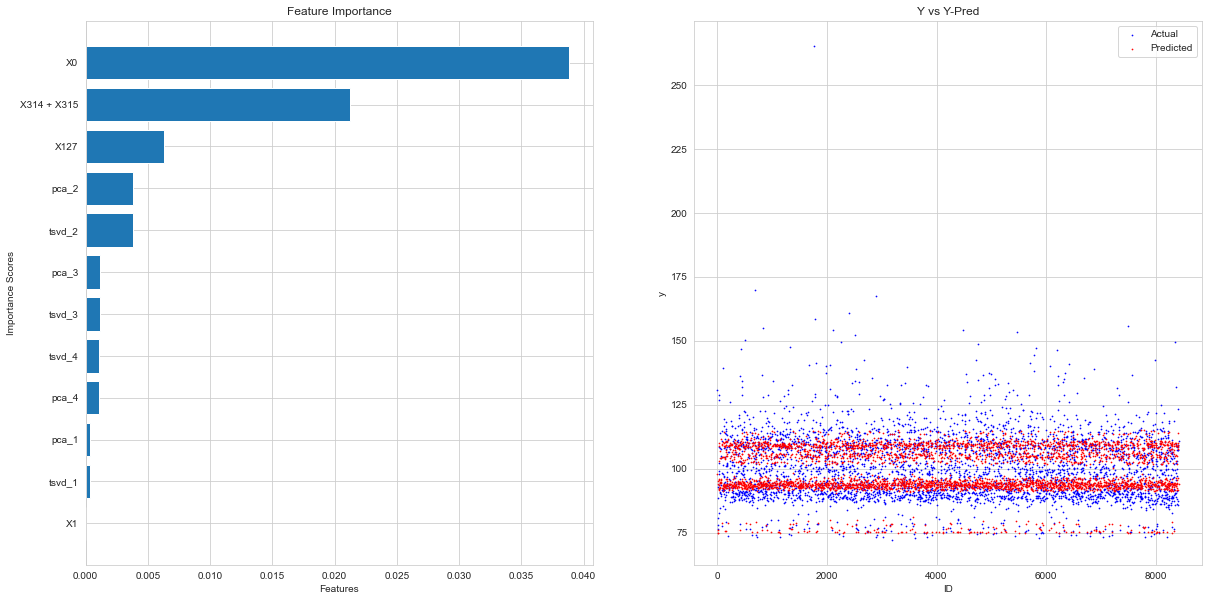

In [ ]:
zipped = zip(list(np.absolute(sgd.best_estimator_.coef_)), final_features)
zipped = sorted(zipped, reverse=True, key= lambda x: x[0])[:12]
imp_scores, features = zip(*zipped)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.barh(features[::-1], imp_scores[::-1])
plt.xlabel("Features"); plt.ylabel("Importance Scores"); plt.title("Feature Importance")
plt.subplot(1,2,2)
plt.scatter(train["ID"].tolist(), y, color='b', label="Actual", s=0.5)
plt.scatter(train["ID"].tolist(), y_pred, color='r', label="Predicted", s=0.5)
plt.xlabel("ID"); plt.ylabel("y"); plt.title("Y vs Y-Pred"); plt.legend()
plt.show()

In [ ]:
sgd_score = metric_pipeline("train.csv", sgd)
print("Train R2-score:\t", sgd_score)
sgd_submission = inference_pipeline("test.csv", sgd)
sgd_submission.to_csv("sgd_submission.csv", index=False)
sgd_submission.head()

Train R2-score:	 0.5592534839131778


,ID,y
0,1,75.319024
1,2,93.457375
2,3,77.326777
3,4,74.812339
4,5,111.302422


<a href="https://imgur.com/d5Sapgw"><img src="https://i.imgur.com/d5Sapgw.png" title="source: imgur.com" /></a>

In [ ]:
print("\n=== Hyperparameter Tuning - XGBRegressor ===\n")
xgb = XGBRegressor(tol=1e-5, base_score=np.mean(np.log(y)), random_state=21)

# define search space
space = dict()
space['n_estimators']     = [x*100 for x in range(1, 20)]
space['max_depth']        = [x     for x in range(1, 10)] 
space['objective']        = ['reg:squarederror', PseudoHuberLoss]
space['learning_rate']    = loguniform(1e-5, 1)
space['gamma']            = loguniform(1e-5, 1)
space['reg_alpha']        = loguniform(1e-5, 100)
space['reg_lambda']       = loguniform(1e-5, 100)
space['colsample_bytree'] = uniform(0, 1)
space['subsample']        = uniform(0, 1)


# define search
xgb = RandomizedSearchCV(xgb, space, scoring=R2_score, cv=2, n_jobs=-1, verbose=1, n_iter=200, random_state=21)

# execute search
result = xgb.fit(X, np.log(y))

# summarize result
print(f'\nBest Hyperparameters\t: {result.best_params_}')
print(f'\nBest CV Score  \t\t: {result.best_score_}')
xgb_params = result.best_params_

y_pred = np.exp(xgb.predict(X))
xgb_score = r2_score(y, y_pred)
print(f'\nOverall Score \t\t: {xgb_score}')
joblib. dump(sgd, "xgb_object.pkl")


=== Hyperparameter Tuning - XGBRegressor ===

Fitting 2 folds for each of 200 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 46.6min finished



Best Hyperparameters	: {'colsample_bytree': 0.8755029725715628, 'gamma': 0.00034743123802471825, 'learning_rate': 0.27683000085842757, 'max_depth': 1, 'n_estimators': 200, 'objective': 'reg:squarederror', 'reg_alpha': 0.3478994027413663, 'reg_lambda': 23.817823763826663, 'subsample': 0.6232424365535488}

Best CV Score  		: 0.4988200323116835

Overall Score 		: 0.614671286832623


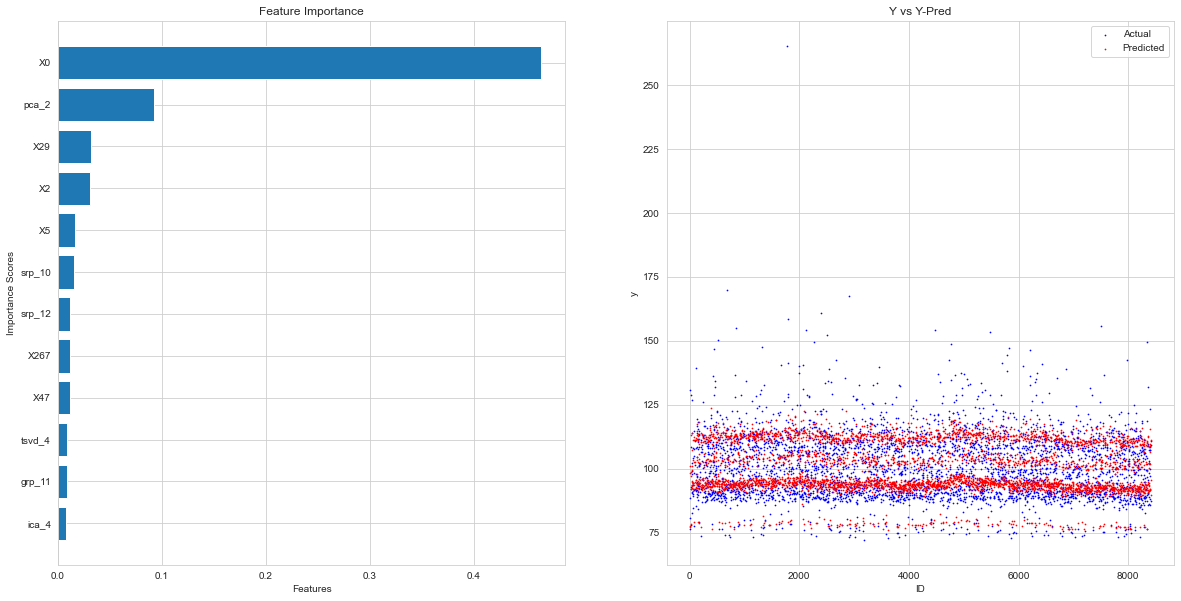

In [ ]:
zipped = zip(list(np.absolute(xgb.best_estimator_.feature_importances_)), final_features)
zipped = sorted(zipped, reverse=True, key= lambda x: x[0])[:12]
imp_scores, features = zip(*zipped)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.barh(features[::-1], imp_scores[::-1])
plt.xlabel("Features"); plt.ylabel("Importance Scores"); plt.title("Feature Importance")
plt.subplot(1,2,2)
plt.scatter(train["ID"].tolist(), y,      color='b', label="Actual",    s=0.5)
plt.scatter(train["ID"].tolist(), y_pred, color='r', label="Predicted", s=0.5)
plt.xlabel("ID"); plt.ylabel("y"); plt.title("Y vs Y-Pred"); plt.legend()
plt.show()

In [ ]:
xgb_score = metric_pipeline("train.csv", xgb)
print("Train R2-score:\t", xgb_score)
xgb_submission = inference_pipeline("test.csv", xgb)
xgb_submission.to_csv("xgb_submission.csv", index=False)
xgb_submission.head()

Train R2-score:	 0.572697692927882


,ID,y
0,1,80.164009
1,2,93.872749
2,3,80.613457
3,4,80.096039
4,5,112.292061


<a href="https://imgur.com/Xt71rW9"><img src="https://i.imgur.com/Xt71rW9.png" title="source: imgur.com" /></a>

In [ ]:
print("\n=== Hyperparameter Tuning - GradientBoostingRegressor ===\n")
gbr = GradientBoostingRegressor(tol=1e-5,  min_samples_leaf=18, min_samples_split=14, random_state=21)

# define search space
space = dict()
space['loss']          = ['ls', 'lad', 'huber', 'quantile']
space['learning_rate'] = loguniform(1e-5, 1)
space['max_depth']     = [x     for x in range(1, 10)] 
space['subsample']     = uniform(0, 1)
space['criterion']     = ['mse', 'mae', "friedman_mse"]
space['n_estimators']  = [x*100 for x in range(2, 11)]
# space['max_samples']   = uniform(0,1)
# space['ccp_alpha']     = uniform(0,1)
# define search
gbr = RandomizedSearchCV(gbr, space, scoring=R2_score, cv=2, n_iter=40, n_jobs=-1, verbose=1, random_state=21)

# execute search
result = gbr.fit(X, np.log(y))

# summarize result
print(f'\nBest Hyperparameters\t: {result.best_params_}')
print(f'\nBest CV Score  \t\t: {result.best_score_}')
gbr_params = result.best_params_

y_pred = np.exp(gbr.predict(X))
# rf_score = r2_score(np.exp(y_val), np.exp(y_pred))
gbr_score = r2_score(y, y_pred)
print(f'\nOverall Score \t\t: {gbr_score}')
joblib. dump(gbr, "gbr_object.pkl")


=== Hyperparameter Tuning - GradientBoostingRegressor ===

Fitting 2 folds for each of 40 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 49.1min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 204.2min finished



Best Hyperparameters	: {'criterion': 'mse', 'learning_rate': 0.06364735323857483, 'loss': 'lad', 'max_depth': 1, 'n_estimators': 400, 'subsample': 0.2986922916088657}

Best CV Score  		: 0.4873192468551788

Overall Score 		: 0.555530190781795


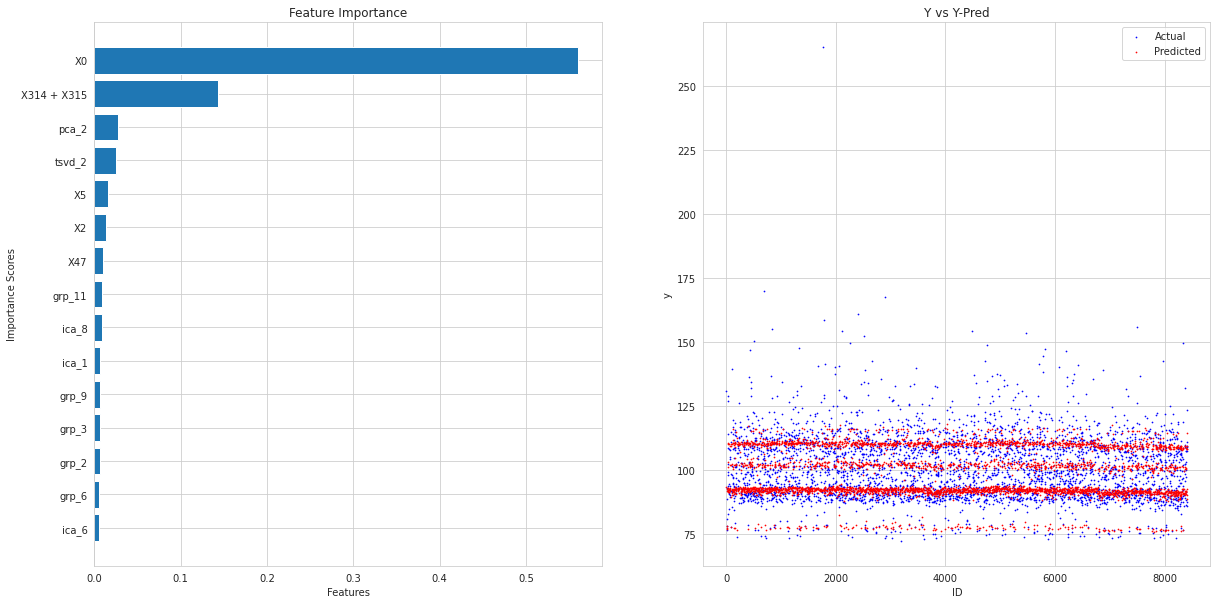

In [ ]:
zipped = zip(list(np.absolute(gbr.best_estimator_.feature_importances_)), final_features)
zipped = sorted(zipped, reverse=True, key= lambda x: x[0])[:15]
imp_scores, features = zip(*zipped)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.barh(features[::-1], imp_scores[::-1])
plt.xlabel("Features"); plt.ylabel("Importance Scores"); plt.title("Feature Importance")
plt.subplot(1,2,2)
plt.scatter(train["ID"].tolist(), y, color='b', label="Actual", s=0.5)
plt.scatter(train["ID"].tolist(), y_pred, color='r', label="Predicted", s=0.5)
plt.xlabel("ID"); plt.ylabel("y"); plt.title("Y vs Y-Pred"); plt.legend()
plt.show()

In [ ]:
gbr_score = metric_pipeline("train.csv", gbr)
print("Train R2-score:\t", gbr_score)
gbr_submission = inference_pipeline("test.csv", gbr)
gbr_submission.to_csv("gbr_submission.csv", index=False)
gbr_submission.head()

Train R2-score:	 0.5493109576499539


,ID,y
0,1,77.861317
1,2,91.319518
2,3,78.065042
3,4,77.948631
4,5,110.692270


<a href="https://imgur.com/XE2WJga"><img src="https://i.imgur.com/XE2WJga.png" title="source: imgur.com" /></a>

In [ ]:
rfr = RandomForestRegressor(max_depth=None, criterion="mae", min_samples_leaf=18, min_samples_split=14, random_state=999)
rfr.fit(X, np.log(y))

y_pred = np.exp(rfr.predict(X))
# rf_score = r2_score(np.exp(y_val), np.exp(y_pred))
rfr_score = r2_score(y, y_pred)
print(f'\nOverall Score \t\t: {rfr_score}')

joblib. dump(rfr, "rfr_object.pkl")


Overall Score 		: 0.6110108101549182


['rfr_object.pkl']

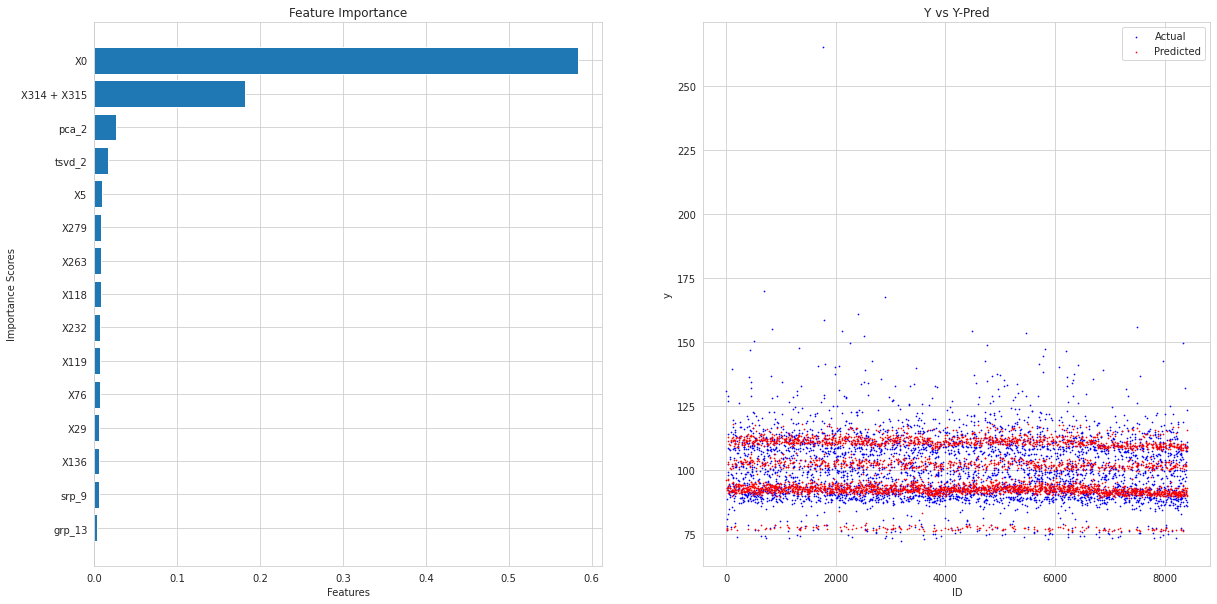

In [ ]:
zipped = zip(list(np.absolute(rfr.feature_importances_)), final_features)
zipped = sorted(zipped, reverse=True, key= lambda x: x[0])[:15]
imp_scores, features = zip(*zipped)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.barh(features[::-1], imp_scores[::-1])
plt.xlabel("Features"); plt.ylabel("Importance Scores"); plt.title("Feature Importance")
plt.subplot(1,2,2)
plt.scatter(train["ID"].tolist(), y, color='b', label="Actual", s=0.5)
plt.scatter(train["ID"].tolist(), y_pred, color='r', label="Predicted", s=0.5)
plt.xlabel("ID"); plt.ylabel("y"); plt.title("Y vs Y-Pred"); plt.legend()
plt.show()

In [ ]:
rfr_score = metric_pipeline("train.csv", rfr)
print("Train R2-score:\t", rfr_score)
rfr_submission = inference_pipeline("test.csv", rfr)
rfr_submission.to_csv("rfr_submission.csv", index=False)
rfr_submission.head()

Train R2-score:	 0.602754521241422


,ID,y
0,1,76.870497
1,2,92.711672
2,3,76.607218
3,4,77.076342
4,5,112.070813


<a href="https://imgur.com/n1l8kaj"><img src="https://i.imgur.com/n1l8kaj.png" title="source: imgur.com" /></a>

In [ ]:
sgd = joblib.load("sgd_object.pkl")
xgb = joblib.load("xgb_object.pkl")
gbr = joblib.load("gbr_object.pkl")
rfr = joblib.load("rfr_object.pkl")

## Final Model

In [ ]:
models = list()
models.append(('xgb', XGBRegressor(tol=1e-7, importance_type="total_cover", base_score=np.mean(np.log(y)), random_state=999,**xgb.best_params_)))
models.append(('gbr', GradientBoostingRegressor(tol=1e-7,  min_samples_leaf=120, min_samples_split=100, random_state=999, **gbr.best_params_)))
models.append(('sgd', SGDRegressor(tol=1e-7, max_iter=100, random_state=100, **sgd.best_params_)))
models.append(('rfr', RandomForestRegressor(max_depth=None, criterion="mae", min_samples_leaf=18, min_samples_split=14, random_state=999)))

# define meta learner model
# meta_classifier = DecisionTreeRegressor(min_samples_leaf=18, min_samples_split=14, random_state=0)
meta_classifier = RidgeCV(cv=10, scoring=R2_score)

# define the stacking ensemble
model = StackingRegressor(estimators=models, final_estimator=meta_classifier, cv=10)

# fit the model on all available data
model.fit(X, np.log(y))

# make a prediction for one example
y_pred = np.exp(model.predict(X))
print("R2 score for stacked Model :", r2_score(y, y_pred))

R2 score for stacked Model : 0.5972838812754858


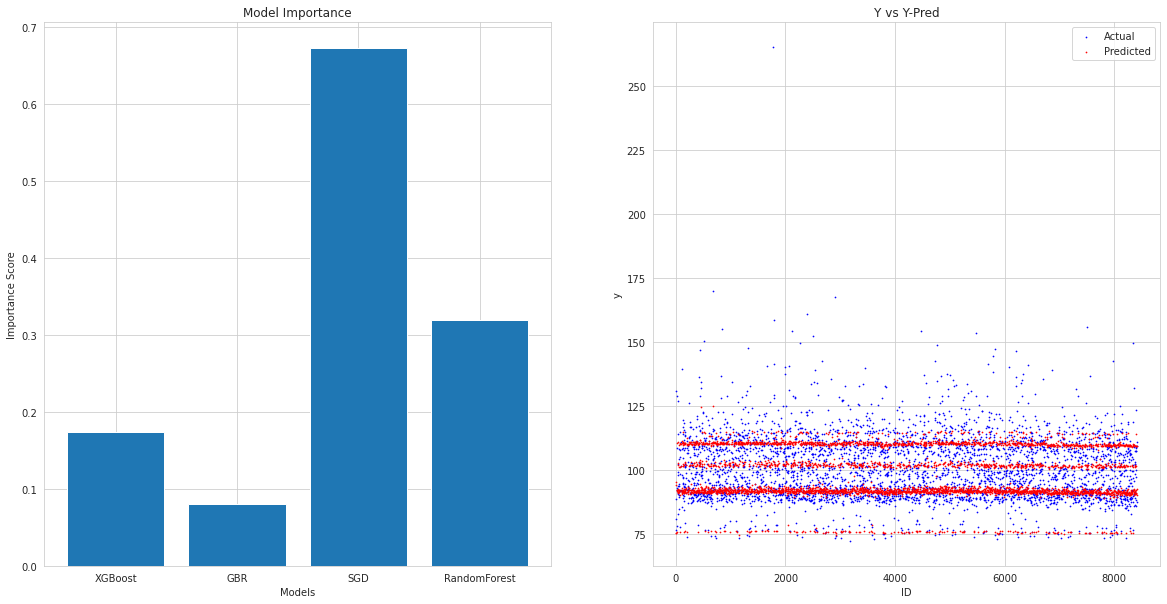

In [ ]:
model_weights = np.absolute(model.final_estimator_.coef_)
model_names   = ['XGBoost', 'GBR', 'SGD', 'RandomForest']

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.bar(model_names, model_weights)
plt.title('Model Importance')
plt.xlabel('Models'); plt.ylabel('Importance Score')
plt.subplot(1,2,2)
plt.scatter(train["ID"].tolist(), y, color='b', label="Actual", s=0.5)
plt.scatter(train["ID"].tolist(), y_pred-2, color='r', label="Predicted", s=0.5)
plt.xlabel("ID"); plt.ylabel("y"); plt.title("Y vs Y-Pred"); plt.legend()
plt.show()

In [ ]:
joblib. dump(model, "model.pkl")

['model.pkl']

In [ ]:
stacked_score = metric_pipeline("train.csv", model)
print("Train R2-score:\t", stacked_score)
stacked_submission = inference_pipeline("test.csv", model)
stacked_submission.to_csv('stacked_submission.csv', index=False)
stacked_submission.head()

Train R2-score:	 0.5903056235376779


,ID,y
0,1,77.519561
1,2,94.290620
2,3,77.788318
3,4,77.406914
4,5,112.470019


<a href="https://imgur.com/CMBiJFb"><img src="https://i.imgur.com/CMBiJFb.png" title="source: imgur.com" /></a>

# Private Leaderboard Score

<a href="https://imgur.com/SNZCf5w"><img src="https://i.imgur.com/SNZCf5w.png" title="source: imgur.com" /></a>

## Pickle Files for the Pipeline

In [ ]:
import pickle, os, shutil
from google.colab import files

pickle_objects = ["target_encoder", "scaler", "pca", "ica", "tsvd", "grp", "srp", "model"]
pickle_objects_path = "./pickle_objects"

if not os.path.exists(pickle_objects_path):
    os.mkdir(pickle_objects_path)
else:
    shutil.rmtree(pickle_objects_path)
    os.mkdir(pickle_objects_path)

for pickle_object in pickle_objects:
    with open(os.path.join(pickle_objects_path, pickle_object+".pkl"), "wb") as f:
        pickle.dump(eval(pickle_object), f)
os.system(f"zip -r pickle_objects.zip {pickle_objects_path}")
files.download("pickle_objects.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Constants used in the pipeline

In [ ]:
with open("constants.py", "w") as f:
    f.write(f"categorical_columns = {str(categorical_columns)}\n")
    f.write(f"binary_columns = {str(binary_columns)}\n")
    f.write(f"final_features = {str(final_features)}\n")
    f.write(f"n_comp = {n_comp}\n")
    f.write(f"pickle_objects_path = './pickle_objects'\n")
    f.write(f"pickle_objects = ['target_encoder', 'scaler', 'pca', 'ica', 'tsvd', 'grp', 'srp', 'model']\n")